# Coursera IBM Data Science Capstone Project - Chris Robinson
# Neighborhood Crime Trend Analysis using FourSquare Data

## Import initial set of needed Python packages

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

from unicodedata import normalize

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

print('Libraries imported.')

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.

Libraries imported.


# Introduction and Problem Description

Washington DC (DC) and New York City (NYC) are cities that offer a wide variety of local venues to satisfy the social, cultural, economic, spiritual, and day-to-day needs of its residents and visitors. As with most large cities, public safety is an ongoing challenge. Predicting patterns of criminal activity is key enabler for improving public safety. This study will make use of local venue data for DC and NYC neighborhoods to derive features that provide a measure of the activity and heterogeneity of the neighborhood venues. I will test this feature as a predictor of criminal activity using both cluster analysis and regression analysis. 

### Problem statement:
Predict patterns of local crime activity in large city neighborhoods based on statistics that measure the number and variety of local neighborhood venues. These predictions will be useful in improving public safety by informing the general public and public safety officials on how criminal activity is associated with the distribution of venues in a local neighborhood.

# Load and Clean Washington DC Neighborhood and Crime Data

In [ ]:
#Load Washington DC neighborhood labels and location data
df_DCneigh_coords = pd.read_csv('WashDCNeighborhood_Labels.csv')
df_DCneigh_coords.head()

In [ ]:
#Load Washington DC crime data for last two years
df_DCcrimes = pd.read_csv('dc-crimes-search-results_cleaned.csv')
df_DCcrimes.head()

In [ ]:
#Create a new dataframe to extract just the columns needed --> incident locations, data/time, and offense type.
df_DCcrimes_1 = df_DCcrimes[['Date','OffenseType','Latitude','Longitude']]
df_DCcrimes_1.head()
df_DCcrimes_1.shape

In [ ]:
#Convert date-time strings in Date column to date-time objects
df_DCcrimes_1['Date']=pd.to_datetime(df_DCcrimes_1['Date'])
df_DCcrimes_1.head()
#Extract only crimes that happened in 2019
start_date = '2019-01-01 00:00:01'
end_date = '2019-12-31 23:59:59'
df_DCcrimes_2019 = df_DCcrimes_1.loc[(df_DCcrimes_1['Date'] >= start_date) & (df_DCcrimes_1['Date'] <= end_date)].reset_index(drop=True)
print(df_DCcrimes_2019.shape)
df_DCcrimes_2019.head()
df_DCcrimes_2019.tail()

In [ ]:
df_DCcrimes_2019.head()

## Loop through DC neighborhoods and count the number of local crime incidents in 2019. Add columns to the dataframe to capture the results.

In [ ]:
#Loop through each DC neighborhood and count the number of crime incidents in 2019 within a specified radius 
df_DCneigh = df_DCneigh_coords
from geopy import distance
radius = 500
TotalCrimes = []
ViolentCrimes = []
PropertyCrimes = []
for lat,long in zip(df_DCneigh['Latitude'],df_DCneigh['Longitude']):
    crime_count = 0
    violent_count = 0
    property_count = 0 
    neigh_pt = (lat, long)
    for j, (crime_lat, crime_long) in enumerate(zip(df_DCcrimes_2019['Latitude'], df_DCcrimes_2019['Longitude'])):
            crime_pt = (crime_lat, crime_long)
            crime_dist = distance.distance(neigh_pt, crime_pt).meters
            if crime_dist <= radius:
                crime_count = crime_count + 1
                if df_DCcrimes_2019['OffenseType'][j] == 'violent':
                    violent_count = violent_count + 1
                else: 
                    property_count = property_count + 1 
    TotalCrimes.append(crime_count) 
    ViolentCrimes.append(violent_count) 
    PropertyCrimes.append(property_count)
df_DCneigh['TotalCrimes'] = TotalCrimes
df_DCneigh['ViolentCrimes'] = ViolentCrimes
df_DCneigh['PropertyCrimes'] = PropertyCrimes
df_DCneigh.head()

df_DCneigh.head()

# Save dataframe with tabulated crime totals to external files. Retrieve data for situations where Python kernel restarts are needed.

In [ ]:
df_DCneigh.to_csv('DCneigh_crime_totals_2019.csv')

In [3]:
df_DCneigh = pd.read_csv('DCneigh_crime_totals_2019.csv')
df_DCneigh.head()

Unnamed: 0           Neighborhood   Latitude  Longitude  TotalCrimes  \
0           0           Fort Stanton  38.855658 -76.980348           47   
1           1       Congress Heights  38.841077 -76.997950          147   
2           2   Washington Highlands  38.830237 -76.995636          212   
3           3               Bellevue  38.826952 -77.009271          151   
4           4  Knox Hill/Buena Vista  38.853688 -76.967660          220   

   ViolentCrimes  PropertyCrimes  
0             17              30  
1             50              97  
2             53             159  
3             45             106  
4             58             162

In [4]:
df_DCneigh.shape

(132, 7)

# Visualize neighboorhoods on a map

In [5]:
# Use Geopy to get the location of Washington DC"
address = 'Washington, District of Columbia'

geolocator = Nominatim(user_agent="WashingtonDCexplore")
location = geolocator.geocode(address)
DClatitude = location.latitude
DClongitude = location.longitude
print('The geograpical coordinate of Washington, DC are {}, {}.'.format(DClatitude, DClongitude))

The geograpical coordinate of Washington, DC are 38.889059149999994, -77.04016998008728.


In [6]:
# create map of DC using latitude and longitude values
map_DC = folium.Map(location=[DClatitude, DClongitude], zoom_start=12)

# add markers to map
for lat, lng, neighborhood in zip(df_DCneigh['Latitude'], df_DCneigh['Longitude'], df_DCneigh['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_DC)  
    
map_DC

# Get FourSquare data for Washington DC neighborhoods

In [7]:
CLIENT_ID = 'XGDUVKQRUPQLETE4NXNCEVS1AHQ4HGFFBEUOWQWVL2DL1XE4' # my Foursquare ID
CLIENT_SECRET = 'L0LK1XK24LNOHNJOWDSUMQ0CDBEHX2XGYUKYSBIZUBOXHWUA' # my Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value
radius = 500

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: XGDUVKQRUPQLETE4NXNCEVS1AHQ4HGFFBEUOWQWVL2DL1XE4
CLIENT_SECRET:L0LK1XK24LNOHNJOWDSUMQ0CDBEHX2XGYUKYSBIZUBOXHWUA


In [8]:
ACCESS_TOKEN = 'W1ZKL2IRUMZ04LEB0GTRK1WHH21IVIEFFCC0DVQIJ4JQ1F4X' #my Foursquare access token

## Define a function to explore venues for a set of neighborhoods (reused from earlier coursera lab)

In [9]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['id'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue ID',                             
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [10]:
df_DC_venues = getNearbyVenues(names=df_DCneigh['Neighborhood'],
                                   latitudes=df_DCneigh['Latitude'],
                                   longitudes=df_DCneigh['Longitude']
                                  )

Fort Stanton
Congress Heights
Washington Highlands
Bellevue
Knox Hill/Buena Vista
Shipley
Douglass
Woodland
Garfield Heights
Near Southeast
Capitol Hill
Dupont Park
Twining
Randle Highlands
Fairlawn
Penn Branch
Barry Farm
Historic Anacostia
Columbia Heights
Logan Circle/Shaw
Cardozo/Shaw
Van Ness
Forest Hills
Georgetown Reservoir
Foxhall Village
Fort Totten
Pleasant Hill
Kenilworth
Eastland Gardens
Deanwood
Fort Dupont
Greenway
Woodland-Normanstone
Mass. Ave. Heights
Naylor Gardens
Pleasant Plains
Hillsdale
Benning Ridge
Penn Quarter
Chinatown
Stronghold
South Central
Langston
Downtown East
North Portal Estates
Colonial Village
Shepherd Park
Takoma
Lamond Riggs
Petworth
Brightwood Park
Manor Park
Brightwood
Hawthorne
Barnaby Woods
Queens Chapel
Michigan Park
North Michigan Park
Woodridge
University Heights
Brookland
Edgewood
Skyland
Bloomingdale
Lincoln Park
16th Street Heights
Fort Lincoln
Gateway
Langdon
Brentwood
Eckington
Truxton Circle
Ivy City
Trinidad
Arboretum
Carver
Mount Vern

In [11]:
df_DC_venues.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0      Fort Stanton              38.855658              -76.980348   
1      Fort Stanton              38.855658              -76.980348   
2      Fort Stanton              38.855658              -76.980348   
3      Fort Stanton              38.855658              -76.980348   
4  Congress Heights              38.841077              -76.997950   

                                   Venue                  Venue ID  \
0             Anacostia Community Museum  4b4cd6d6f964a52015c126e3   
1         Fort Stanton Recreation Center  56d8c6becd108d4b2da55ea1   
2                      Fort Stanton Park  4cd170596200b1f73dd8d928   
3  Stanton Road SE & Suitland Parkway SE  4e2def58b0fbdc2b64f27692   
4                               MLK Deli  4ca26b675720b1f7bf0229ef   

   Venue Latitude  Venue Longitude     Venue Category  
0       38.856728       -76.976899             Museum  
1       38.857118       -76.978816  Recreation Center  
2       38.857541       -76.978266               Park  
3       38.853278       -76.983289       Intersection  
4       38.843560       -76.999808      Deli / Bodega

In [12]:
df_DC_venues.to_csv('DC_venues_2019.csv') #Save above output to .CSV file

# Analyze venue categories and group DC venue data by neighboorhood

In [13]:
df_DCneigh_totalvenues = pd.DataFrame(df_DC_venues.groupby('Neighborhood').count())
df_DCneigh_totalvenues.rename(columns = {'Venue':'Total Venues'}, inplace = True) 
df_DCneigh_totalvenues.head()

Neighborhood Latitude  Neighborhood Longitude  \
Neighborhood                                                              
16th Street Heights                          14                      14   
Adams Morgan                                 56                      56   
American University Park                      2                       2   
Arboretum                                    16                      16   
Barnaby Woods                                 4                       4   

                          Total Venues  Venue ID  Venue Latitude  \
Neighborhood                                                       
16th Street Heights                 14        14              14   
Adams Morgan                        56        56              56   
American University Park             2         2               2   
Arboretum                           16        16              16   
Barnaby Woods                        4         4               4   

                          Venue Longitude  Venue Category  
Neighborhood                                               
16th Street Heights                    14              14  
Adams Morgan                           56              56  
American University Park                2               2  
Arboretum                              16              16  
Barnaby Woods                           4               4

In [14]:
df_DCneigh_totalvenues.shape

(131, 7)

In [15]:
df_DCneigh_totalvenues.describe()

Neighborhood Latitude  Neighborhood Longitude  Total Venues  \
count             131.000000              131.000000    131.000000   
mean               19.251908               19.251908     19.251908   
std                22.993760               22.993760     22.993760   
min                 1.000000                1.000000      1.000000   
25%                 5.000000                5.000000      5.000000   
50%                 8.000000                8.000000      8.000000   
75%                25.000000               25.000000     25.000000   
max               100.000000              100.000000    100.000000   

         Venue ID  Venue Latitude  Venue Longitude  Venue Category  
count  131.000000      131.000000       131.000000      131.000000  
mean    19.251908       19.251908        19.251908       19.251908  
std     22.993760       22.993760        22.993760       22.993760  
min      1.000000        1.000000         1.000000        1.000000  
25%      5.000000        5.000000         5.000000        5.000000  
50%      8.000000        8.000000         8.000000        8.000000  
75%     25.000000       25.000000        25.000000       25.000000  
max    100.000000      100.000000       100.000000      100.000000

In [16]:
# one hot encoding
DC_onehot = pd.get_dummies(df_DC_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
DC_onehot['Neighborhood'] = df_DC_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [DC_onehot.columns[-1]] + list(DC_onehot.columns[:-1])
DC_onehot = DC_onehot[fixed_columns]

DC_onehot.head()

Zoo Exhibit  ATM  Afghan Restaurant  American Restaurant  Antique Shop  \
0            0    0                  0                    0             0   
1            0    0                  0                    0             0   
2            0    0                  0                    0             0   
3            0    0                  0                    0             0   
4            0    0                  0                    0             0   

   Arepa Restaurant  Art Gallery  Art Museum  Arts & Crafts Store  \
0                 0            0           0                    0   
1                 0            0           0                    0   
2                 0            0           0                    0   
3                 0            0           0                    0   
4                 0            0           0                    0   

   Arts & Entertainment  ...  Volleyball Court  Warehouse Store  Whisky Bar  \
0                     0  ...                 0                0           0   
1                     0  ...                 0                0           0   
2                     0  ...                 0                0           0   
3                     0  ...                 0                0           0   
4                     0  ...                 0                0           0   

   Wine Bar  Wine Shop  Winery  Wings Joint  Women's Store  \
0         0          0       0            0              0   
1         0          0       0            0              0   
2         0          0       0            0              0   
3         0          0       0            0              0   
4         0          0       0            0              0   

   Xinjiang Restaurant  Yoga Studio  
0                    0            0  
1                    0            0  
2                    0            0  
3                    0            0  
4                    0            0  

[5 rows x 303 columns]

In [17]:
DC_onehot.shape

(2522, 303)

## Group DC venue data by neighboorhood and determine frequency of each venue categories and sum of each venue category for each neigborhood.

In [18]:
DC_grouped_mean = DC_onehot.groupby('Neighborhood').mean().reset_index()
DC_grouped_mean

Neighborhood  Zoo Exhibit  ATM  Afghan Restaurant  \
0         16th Street Heights     0.000000  0.0           0.000000   
1                Adams Morgan     0.000000  0.0           0.017857   
2    American University Park     0.000000  0.0           0.000000   
3                   Arboretum     0.000000  0.0           0.000000   
4               Barnaby Woods     0.000000  0.0           0.000000   
..                        ...          ...  ...                ...   
126                  West End     0.000000  0.0           0.000000   
127                  Woodland     0.000000  0.0           0.000000   
128      Woodland-Normanstone     0.000000  0.0           0.000000   
129              Woodley Park     0.111111  0.0           0.000000   
130                 Woodridge     0.000000  0.0           0.000000   

     American Restaurant  Antique Shop  Arepa Restaurant  Art Gallery  \
0               0.000000           0.0               0.0          0.0   
1               0.000000           0.0               0.0          0.0   
2               0.000000           0.0               0.0          0.0   
3               0.062500           0.0               0.0          0.0   
4               0.000000           0.0               0.0          0.0   
..                   ...           ...               ...          ...   
126             0.040816           0.0               0.0          0.0   
127             0.000000           0.0               0.0          0.0   
128             0.000000           0.0               0.0          0.0   
129             0.000000           0.0               0.0          0.0   
130             0.000000           0.0               0.0          0.0   

     Art Museum  Arts & Crafts Store  ...  Volleyball Court  Warehouse Store  \
0           0.0                  0.0  ...               0.0              0.0   
1           0.0                  0.0  ...               0.0              0.0   
2           0.0                  0.0  ...               0.0              0.0   
3           0.0                  0.0  ...               0.0              0.0   
4           0.0                  0.0  ...               0.0              0.0   
..          ...                  ...  ...               ...              ...   
126         0.0                  0.0  ...               0.0              0.0   
127         0.0                  0.0  ...               0.0              0.0   
128         0.0                  0.0  ...               0.0              0.0   
129         0.0                  0.0  ...               0.0              0.0   
130         0.0                  0.0  ...               0.0              0.0   

     Whisky Bar  Wine Bar  Wine Shop  Winery  Wings Joint  Women's Store  \
0      0.000000  0.000000        0.0     0.0          0.0            0.0   
1      0.017857  0.000000        0.0     0.0          0.0            0.0   
2      0.000000  0.000000        0.0     0.0          0.0            0.0   
3      0.000000  0.000000        0.0     0.0          0.0            0.0   
4      0.000000  0.000000        0.0     0.0          0.0            0.0   
..          ...       ...        ...     ...          ...            ...   
126    0.000000  0.020408        0.0     0.0          0.0            0.0   
127    0.000000  0.000000        0.0     0.0          0.0            0.0   
128    0.000000  0.000000        0.0     0.0          0.0            0.0   
129    0.000000  0.000000        0.0     0.0          0.0            0.0   
130    0.000000  0.000000        0.0     0.0          0.0            0.0   

     Xinjiang Restaurant  Yoga Studio  
0                    0.0     0.000000  
1                    0.0     0.000000  
2                    0.0     0.000000  
3                    0.0     0.000000  
4                    0.0     0.000000  
..                   ...          ...  
126                  0.0     0.020408  
127                  0.0     0.000000  
128                  0.0     0.000000  
129                  0.0 

In [19]:
DC_grouped_sum = DC_onehot.groupby('Neighborhood').sum().reset_index()
DC_grouped_sum

Neighborhood  Zoo Exhibit  ATM  Afghan Restaurant  \
0         16th Street Heights            0    0                  0   
1                Adams Morgan            0    0                  1   
2    American University Park            0    0                  0   
3                   Arboretum            0    0                  0   
4               Barnaby Woods            0    0                  0   
..                        ...          ...  ...                ...   
126                  West End            0    0                  0   
127                  Woodland            0    0                  0   
128      Woodland-Normanstone            0    0                  0   
129              Woodley Park            2    0                  0   
130                 Woodridge            0    0                  0   

     American Restaurant  Antique Shop  Arepa Restaurant  Art Gallery  \
0                      0             0                 0            0   
1                      0             0                 0            0   
2                      0             0                 0            0   
3                      1             0                 0            0   
4                      0             0                 0            0   
..                   ...           ...               ...          ...   
126                    2             0                 0            0   
127                    0             0                 0            0   
128                    0             0                 0            0   
129                    0             0                 0            0   
130                    0             0                 0            0   

     Art Museum  Arts & Crafts Store  ...  Volleyball Court  Warehouse Store  \
0             0                    0  ...                 0                0   
1             0                    0  ...                 0                0   
2             0                    0  ...                 0                0   
3             0                    0  ...                 0                0   
4             0                    0  ...                 0                0   
..          ...                  ...  ...               ...              ...   
126           0                    0  ...                 0                0   
127           0                    0  ...                 0                0   
128           0                    0  ...                 0                0   
129           0                    0  ...                 0                0   
130           0                    0  ...                 0                0   

     Whisky Bar  Wine Bar  Wine Shop  Winery  Wings Joint  Women's Store  \
0             0         0          0       0            0              0   
1             1         0          0       0            0              0   
2             0         0          0       0            0              0   
3             0         0          0       0            0              0   
4             0         0          0       0            0              0   
..          ...       ...        ...     ...          ...            ...   
126           0         1          0       0            0              0   
127           0         0          0       0            0              0   
128           0         0          0       0            0              0   
129           0         0          0       0            0              0   
130           0         0          0       0            0              0   

     Xinjiang Restaurant  Yoga Studio  
0                      0            0  
1                      0            0  
2                      0            0  
3                      0            0  
4                      0            0  
..                   ...          ...  
126                    0            1  
127                    0            0  
128                    0            0  
129                    0 

In [22]:
DC_grouped_sum.shape

(131, 303)

## Create a new dataframe that adds "Total Venues" as a feature in the DC neighborhood data set

In [21]:
df_DC_neigh1 = pd.DataFrame(df_DCneigh_totalvenues['Total Venues']).reset_index()
df_DC_neigh1.head()

Neighborhood  Total Venues
0       16th Street Heights            14
1              Adams Morgan            56
2  American University Park             2
3                 Arboretum            16
4             Barnaby Woods             4

## Use the sum of each venue category by DC neighboorhood to calculate an entropy score for that neighborhood. 
## Entropy (from information theory) is a measure of the heterogenity of venue categories within an area.

$$ Escore = - \sum_{c} \frac{N_c}{N} log(\frac{N_c}{N})$$

### Nc = Number of venues of catagory c, c is element of C, where C is the set of venue categories
### N = Total number of venues in a neighboorhood


See "Exploring Foursquare-derived features for crime prediction in New York City" at https://www.cs.uic.edu/~urbcomp2013/urbcomp2016/papers/Exploring.pdf


In [23]:
import math

DC_grouped_temp = DC_grouped_sum.drop('Neighborhood', 1)
E_scores = []
for index, row in DC_grouped_temp.iterrows():
    Num_cats = row.sum()
    E_score = 0
    for x in row:
        if x > 0:
            E_score = E_score + -(x/Num_cats * math.log(x/Num_cats))
    
    E_scores.append(E_score)

df_DC_neigh1['E-scores'] = E_scores #add the entropy scores as a column in the DC neighboorhoods dataframe
        
df_DC_neigh1.head()

Neighborhood  Total Venues  E-scores
0       16th Street Heights            14  2.639057
1              Adams Morgan            56  3.852065
2  American University Park             2  0.693147
3                 Arboretum            16  2.685945
4             Barnaby Woods             4  1.386294

# Merge the DC venues dataframe with the DC crimes dataframe

In [24]:
df_DC_neigh2 = pd.merge(df_DC_neigh1, df_DCneigh, on='Neighborhood', how='left')
df_DC_neigh2.head()


Neighborhood  Total Venues  E-scores  Unnamed: 0   Latitude  \
0       16th Street Heights            14  2.639057          65  38.950315   
1              Adams Morgan            56  3.852065         105  38.920472   
2  American University Park             2  0.693147          94  38.947612   
3                 Arboretum            16  2.685945          74  38.914860   
4             Barnaby Woods             4  1.386294          54  38.975433   

   Longitude  TotalCrimes  ViolentCrimes  PropertyCrimes  
0 -77.033559           78              4              74  
1 -77.042391          473             39             434  
2 -77.090250           35              4              31  
3 -76.972490           86             13              73  
4 -77.060174           36              0              36

In [25]:
df_DC_neigh2 = df_DC_neigh2.drop('Unnamed: 0', axis=1)
df_DC_neigh2.head()

Neighborhood  Total Venues  E-scores   Latitude  Longitude  \
0       16th Street Heights            14  2.639057  38.950315 -77.033559   
1              Adams Morgan            56  3.852065  38.920472 -77.042391   
2  American University Park             2  0.693147  38.947612 -77.090250   
3                 Arboretum            16  2.685945  38.914860 -76.972490   
4             Barnaby Woods             4  1.386294  38.975433 -77.060174   

   TotalCrimes  ViolentCrimes  PropertyCrimes  
0           78              4              74  
1          473             39             434  
2           35              4              31  
3           86             13              73  
4           36              0              36

# Use the DC neighborhood venues frequency data to determine the most common venue categories in each neighborhood

In [26]:
num_top_venues = 5

for hood in DC_grouped_mean['Neighborhood']:
    print("----"+hood+"----")
    temp = DC_grouped_mean[DC_grouped_mean['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 3})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----16th Street Heights----
              venue   freq
0   Bed & Breakfast  0.071
1    Cosmetics Shop  0.071
2    Breakfast Spot  0.071
3              Park  0.071
4  Greek Restaurant  0.071


----Adams Morgan----
              venue   freq
0       Coffee Shop  0.036
1  Asian Restaurant  0.036
2      Cocktail Bar  0.036
3               Spa  0.036
4             Diner  0.036


----American University Park----
                   venue  freq
0     Italian Restaurant   0.5
1              BBQ Joint   0.5
2        Organic Grocery   0.0
3    Peruvian Restaurant   0.0
4  Performing Arts Venue   0.0


----Arboretum----
              venue   freq
0            Garden  0.125
1  Storage Facility  0.062
2   Automotive Shop  0.062
3       Gas Station  0.062
4           Brewery  0.062


----Barnaby Woods----
                  venue  freq
0                 Field  0.25
1                  Park  0.25
2  Gym / Fitness Center  0.25
3             BBQ Joint  0.25
4           Zoo Exhibit  0.00


----Barry Farm--

4    Zoo Exhibit   0.0


----Langston----
                 venue   freq
0   Light Rail Station  0.111
1        Grocery Store  0.111
2  Fried Chicken Joint  0.111
3         Intersection  0.111
4    Convenience Store  0.056


----Lanier Heights----
                      venue   freq
0               Zoo Exhibit  0.077
1               Coffee Shop  0.077
2                Playground  0.051
3          Asian Restaurant  0.051
4  Mediterranean Restaurant  0.051


----Le Droit Park----
                     venue   freq
0              Pizza Place  0.053
1                      Bar  0.053
2             Liquor Store  0.053
3  New American Restaurant  0.035
4        Korean Restaurant  0.035


----Lincoln Heights----
                venue  freq
0      Sandwich Place  0.25
1   Convenience Store  0.25
2  Chinese Restaurant  0.25
3              Garden  0.25
4          Non-Profit  0.00


----Lincoln Park----
          venue   freq
0   Coffee Shop  0.167
1  Liquor Store  0.167
2      Bus Stop  0.167
3   Pi

4  Performing Arts Venue   0.0


----Stanton Park----
               venue   freq
0  Convenience Store  0.333
1        Yoga Studio  0.167
2  Recreation Center  0.167
3               Park  0.167
4          BBQ Joint  0.167


----Stronghold----
           venue   freq
0       Bus Stop  0.250
1  Deli / Bodega  0.125
2           Park  0.125
3     Food Truck  0.125
4            Gym  0.125


----Takoma----
                           venue   freq
0  Vegetarian / Vegan Restaurant  0.091
1                           Park  0.091
2           Caribbean Restaurant  0.091
3                   Liquor Store  0.045
4                Border Crossing  0.045


----Tenleytown----
                  venue   freq
0           Pizza Place  0.061
1     Convenience Store  0.061
2  Gym / Fitness Center  0.041
3    Mexican Restaurant  0.041
4        Mattress Store  0.041


----Trinidad----
                             venue  freq
0                 Asian Restaurant   0.2
1              American Restaurant   0.2
2      

In [27]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [28]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = DC_grouped_mean['Neighborhood']

for ind in np.arange(DC_grouped_mean.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(DC_grouped_mean.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0       16th Street Heights                   Gym                  Food   
1              Adams Morgan           Coffee Shop                 Diner   
2  American University Park    Italian Restaurant             BBQ Joint   
3                 Arboretum                Garden          Intersection   
4             Barnaby Woods  Gym / Fitness Center                  Park   

  3rd Most Common Venue 4th Most Common Venue     5th Most Common Venue  \
0                  Park       Bed & Breakfast               Coffee Shop   
1                   Spa                   Bar  Mediterranean Restaurant   
2           Yoga Studio           Flower Shop            Farmers Market   
3       Automotive Shop           Coffee Shop      Fast Food Restaurant   
4             BBQ Joint                 Field               Yoga Studio   

  6th Most Common Venue 7th Most Common Venue  8th Most Common Venue  \
0    Chinese Restaurant        Gymnastics Gym  Salvadoran Restaurant   
1      Asian Restaurant          Cocktail Bar                   Café   
2  Fast Food Restaurant                 Field    Filipino Restaurant   
3    Chinese Restaurant             Nightclub            Gas Station   
4               Exhibit        Farmers Market   Fast Food Restaurant   

  9th Most Common Venue 10th Most Common Venue  
0           Pizza Place       Greek Restaurant  
1        Clothing Store         Massage Studio  
2     Fish & Chips Shop            Flea Market  
3      Storage Facility       Botanical Garden  
4   Filipino Restaurant      Fish & Chips Shop

# Perform k-means cluster analysis using DC neighborhood venue category frequency features
## Note: k-means cluster analysis was not used in final report

## Explore optimal number of clusters (K) for K-means clustering

In [29]:
import matplotlib.pyplot as plt  
from matplotlib import style
from sklearn import metrics
from sklearn.metrics import pairwise_distances
DC_grouped_clustering = DC_grouped_mean.drop('Neighborhood', 1)
cost =[] 
score = []
for i in range(2, 20): 
    KM = KMeans(n_clusters=i, random_state=0).fit(DC_grouped_clustering) 
      
    # calculates squared error 
    # for the clustered points 
    cost.append(KM.inertia_)
    score.append(metrics.silhouette_score(DC_grouped_clustering, KM.labels_, metric='euclidean'))

Text(0, 0.5, 'Silhouette score')

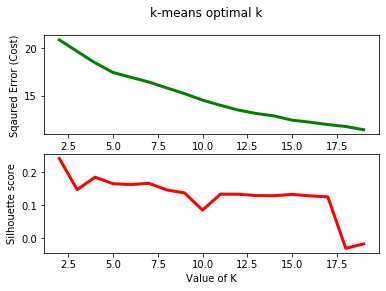

In [30]:
fig, axs = plt.subplots(2)
fig.suptitle('k-means optimal k')
axs[0].plot(range(2, 20), cost, color ='g', linewidth ='3')
axs[0].set_xlabel("Value of K") 
axs[0].set_ylabel("Sqaured Error (Cost)")
axs[1].plot(range(2, 20), score, color='r', linewidth = '3')
axs[1].set_xlabel("Value of K") 
axs[1].set_ylabel("Silhouette score")

In [31]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(DC_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 1, 4, 0, 0, 0, 2, 0, 0,
       0, 0, 2, 1, 2, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 2, 0, 2, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2,
       0, 0, 0, 0, 4, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2])

In [32]:
df_DC_neigh2['KM Cluster Labels'] = kmeans.labels_
df_DC_neigh2.head()

Neighborhood  Total Venues  E-scores   Latitude  Longitude  \
0       16th Street Heights            14  2.639057  38.950315 -77.033559   
1              Adams Morgan            56  3.852065  38.920472 -77.042391   
2  American University Park             2  0.693147  38.947612 -77.090250   
3                 Arboretum            16  2.685945  38.914860 -76.972490   
4             Barnaby Woods             4  1.386294  38.975433 -77.060174   

   TotalCrimes  ViolentCrimes  PropertyCrimes  KM Cluster Labels  
0           78              4              74                  0  
1          473             39             434                  0  
2           35              4              31                  0  
3           86             13              73                  0  
4           36              0              36                  0

In [33]:
df_DC_neigh3=df_DC_neigh2.reindex(columns= ['Neighborhood', 'Latitude','Longitude','Total Venues','E-scores','KM Cluster Labels','TotalCrimes','ViolentCrimes','PropertyCrimes'])
df_DC_neigh3.head(10)



Neighborhood   Latitude  Longitude  Total Venues  E-scores  \
0       16th Street Heights  38.950315 -77.033559            14  2.639057   
1              Adams Morgan  38.920472 -77.042391            56  3.852065   
2  American University Park  38.947612 -77.090250             2  0.693147   
3                 Arboretum  38.914860 -76.972490            16  2.685945   
4             Barnaby Woods  38.975433 -77.060174             4  1.386294   
5                Barry Farm  38.859255 -76.997281             6  1.560710   
6                  Bellevue  38.826952 -77.009271             4  1.386294   
7                   Benning  38.891885 -76.948884            16  2.772589   
8             Benning Ridge  38.881161 -76.938203             4  1.386294   
9              Bloomingdale  38.918226 -77.011159            18  2.813355   

   KM Cluster Labels  TotalCrimes  ViolentCrimes  PropertyCrimes  
0                  0           78              4              74  
1                  0          473             39             434  
2                  0           35              4              31  
3                  0           86             13              73  
4                  0           36              0              36  
5                  0          119             40              79  
6                  0          151             45             106  
7                  0          307             55             252  
8                  0          110             32              78  
9                  0          321             40             281

In [34]:
df_DC_neigh3.describe()

Latitude   Longitude  Total Venues    E-scores  KM Cluster Labels  \
count  131.000000  131.000000    131.000000  131.000000         131.000000   
mean    38.908619  -77.007543     19.251908    2.178224           0.404580   
std      0.034036    0.045160     22.993760    0.974057           0.875114   
min     38.826952  -77.103520      1.000000    0.000000           0.000000   
25%     38.884902  -77.040930      5.000000    1.560710           0.000000   
50%     38.909637  -77.007767      8.000000    2.079442           0.000000   
75%     38.930693  -76.972696     25.000000    2.980885           0.000000   
max     38.991765  -76.917389    100.000000    4.051063           4.000000   

       TotalCrimes  ViolentCrimes  PropertyCrimes  
count   131.000000     131.000000      131.000000  
mean    225.000000      29.106870      195.893130  
std     232.984813      29.497393      212.090628  
min       1.000000       0.000000        1.000000  
25%      83.500000       7.000000       70.000000  
50%     156.000000      22.000000      124.000000  
75%     282.500000      44.000000      249.500000  
max    1459.000000     178.000000     1281.000000

# Plot DC Neighborhood k-means Clusters.

In [35]:
# create map
map_clusters = folium.Map(location=[DClatitude, DClongitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_DC_neigh3['Latitude'], df_DC_neigh3['Longitude'], df_DC_neigh3['Neighborhood'], df_DC_neigh3['KM Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Explore data relationships to predict DC neighborhood crime totals from venue features (Total Venues and Entropy score (E-score))

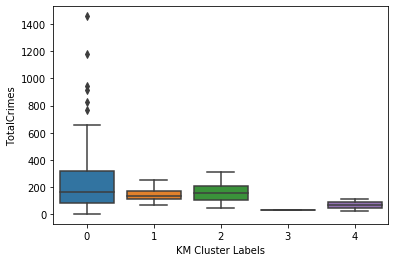

In [36]:
import seaborn as sns
sns.boxplot(x="KM Cluster Labels", y="TotalCrimes", data=df_DC_neigh3)

In [37]:
df_DC_neigh_clustergrouped = df_DC_neigh3.groupby('KM Cluster Labels').mean().reset_index()
df_DC_neigh_clustergrouped1 = df_DC_neigh_clustergrouped[['KM Cluster Labels','TotalCrimes','ViolentCrimes','PropertyCrimes']]
df_DC_neigh_clustergrouped1.columns = ['KM Cluster Label','Average Annual Crimes','Average Annual Violent Crimes','Average Annual Property Crimes']
df_DC_neigh_clustergrouped1.head()

KM Cluster Label  Average Annual Crimes  Average Annual Violent Crimes  \
0                 0             243.304762                      28.580952   
1                 1             147.000000                      27.500000   
2                 2             167.368421                      34.684211   
3                 3              27.000000                       0.000000   
4                 4              66.500000                      21.500000   

   Average Annual Property Crimes  
0                      214.723810  
1                      119.500000  
2                      132.684211  
3                       27.000000  
4                       45.000000

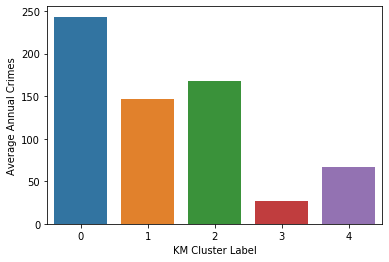

In [38]:
%matplotlib inline
ax = sns.barplot(x="KM Cluster Label", y="Average Annual Crimes", data=df_DC_neigh_clustergrouped1)

# Explore relationship between total venues, venue entropy score and total neighborhood crimes

(0, 1531.9166942604857)

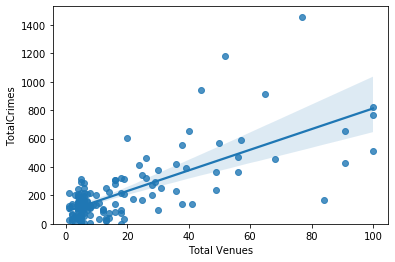

In [39]:
%matplotlib inline 
import seaborn as sns
sns.regplot(x="Total Venues", y="TotalCrimes", data=df_DC_neigh3)
plt.ylim(0,)

(0, 1540.6519140004148)

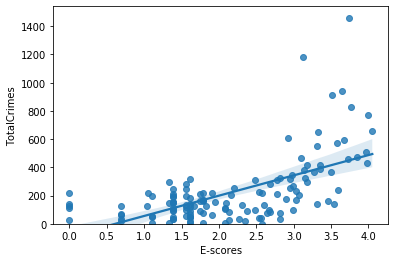

In [40]:
sns.regplot(x="E-scores", y="TotalCrimes", data=df_DC_neigh3)
plt.ylim(0,)

## Define a function to plot polynomial fits to visualize data

In [42]:
def PlotPolly(model, independent_variable, dependent_variable, Name, YName, Title):
    x_range = max(independent_variable)
    x_new = np.linspace(0, x_range, 100)
    y_new = model(x_new)

    plt.plot(independent_variable, dependent_variable, '.', x_new, y_new, '-')
    plt.title(Title)
    ax = plt.gca()
    ax.set_facecolor((0.898, 0.898, 0.898))
    fig = plt.gcf()
    plt.xlabel(Name)
    plt.ylabel(YName)

    plt.show()
    plt.close()

       3         2
22.88 x - 59.98 x + 32.13 x + 119.7


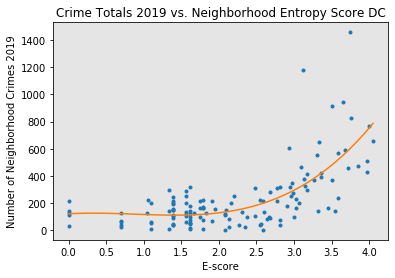

In [43]:
x = df_DC_neigh3['E-scores']
y = df_DC_neigh3['TotalCrimes']
f = np.polyfit(x, y, 3)
p = np.poly1d(f)
print(p)
PlotPolly(p, x, y, 'E-score', 'Number of Neighborhood Crimes 2019', 'Crime Totals 2019 vs. Neighborhood Entropy Score DC')

## Look at the relationship between logarithm of the number of crimes vs. venue entropy score (E-score).

log(y) =          3          2
0.04196 x + 0.1588 x - 0.5266 x + 6.641


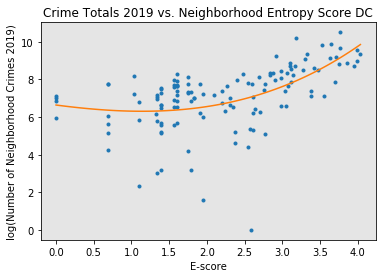

In [242]:
x = df_DC_neigh3['E-scores']
y = df_DC_neigh3['TotalCrimes']
logy = np.log2(y) 
f = np.polyfit(x, logy, 3)
p = np.poly1d(f)
print('log(y) =',p)
PlotPolly(p, x, logy, 'E-score', 'log(Number of Neighborhood Crimes 2019)', 'Crime Totals 2019 vs. Neighborhood Entropy Score DC')

# Use polynomial and multi-variate polynomial regression to predict for Total Crimes with features = 'Total Venues' and 'E-scores'

In [45]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
Z = df_DC_neigh3[['Total Venues', 'E-scores']]
Z1 = df_DC_neigh3[['E-scores']]
Input = [('scale',StandardScaler()), ('polynomial', PolynomialFeatures(degree=4, include_bias=False)), ('model',LinearRegression())]
pipe = Pipeline(Input)
pipe.fit(Z,y)
ypipe = pipe.predict(Z)
y1score = pipe.score(Z,y)
pipe.fit(Z1,y)
ypipe1 = pipe.predict(Z1)
y2score = pipe.score(Z1,y)
print (y1score, y2score)

0.6570437428715153 0.511552536831619


In [46]:
df_DC_neigh4 = df_DC_neigh3
df_DC_neigh4['MVPolyFit_TotalCrimes'] = ypipe
df_DC_neigh4['PolyFit_TotalCrimes'] = ypipe1
df_DC_neigh4.head(10)

Neighborhood   Latitude  Longitude  Total Venues  E-scores  \
0       16th Street Heights  38.950315 -77.033559            14  2.639057   
1              Adams Morgan  38.920472 -77.042391            56  3.852065   
2  American University Park  38.947612 -77.090250             2  0.693147   
3                 Arboretum  38.914860 -76.972490            16  2.685945   
4             Barnaby Woods  38.975433 -77.060174             4  1.386294   
5                Barry Farm  38.859255 -76.997281             6  1.560710   
6                  Bellevue  38.826952 -77.009271             4  1.386294   
7                   Benning  38.891885 -76.948884            16  2.772589   
8             Benning Ridge  38.881161 -76.938203             4  1.386294   
9              Bloomingdale  38.918226 -77.011159            18  2.813355   

   KM Cluster Labels  TotalCrimes  ViolentCrimes  PropertyCrimes  \
0                  0           78              4              74   
1                  0          473             39             434   
2                  0           35              4              31   
3                  0           86             13              73   
4                  0           36              0              36   
5                  0          119             40              79   
6                  0          151             45             106   
7                  0          307             55             252   
8                  0          110             32              78   
9                  0          321             40             281   

   MVPolyFit_TotalCrimes  PolyFit_TotalCrimes  
0             196.658262           202.120950  
1             485.234811           649.467832  
2              31.960649           158.951165  
3             176.043038           213.447780  
4             123.446829           115.166207  
5             174.856919           106.762922  
6             123.446829           115.166207  
7             268.541880           235.987879  
8             123.446829           115.166207  
9             234.776973           247.303064

# Evaluate regression models using distribution plots

In [47]:
def DistributionPlot(RedFunction, BlueFunction, RedName, BlueName, Title):
    width = 12
    height = 10
    plt.figure(figsize=(width, height))

    ax1 = sns.distplot(RedFunction, hist=False, color="r", label=RedName)
    ax2 = sns.distplot(BlueFunction, hist=False, color="b", label=BlueName, ax=ax1)

    plt.title(Title)
    plt.xlabel('Total Neighborhood Crimes 2019')
    plt.ylabel('Frequency')

    plt.show()
    plt.close()

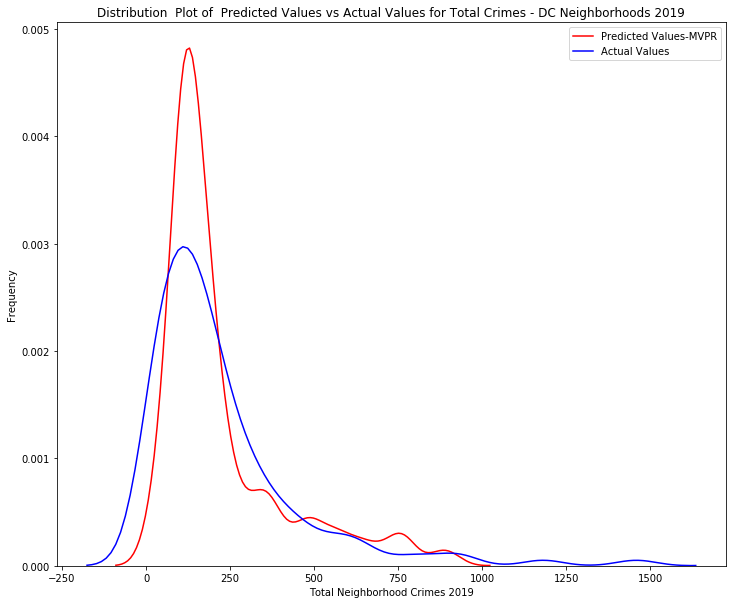

In [48]:
Title = 'Distribution  Plot of  Predicted Values vs Actual Values for Total Crimes - DC Neighborhoods 2019'
y1 = df_DC_neigh4['MVPolyFit_TotalCrimes']
y2 = df_DC_neigh4['TotalCrimes']
DistributionPlot(y1, y2, "Predicted Values-MVPR", "Actual Values", Title)

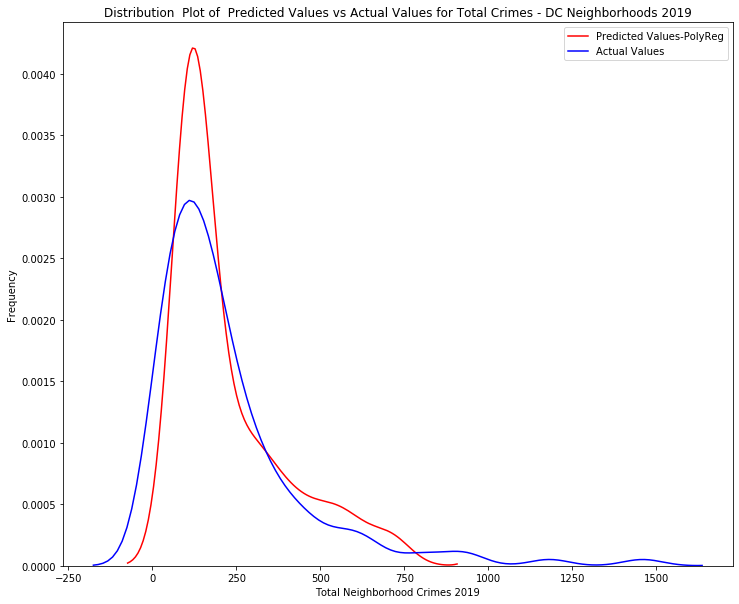

In [49]:
Title = 'Distribution  Plot of  Predicted Values vs Actual Values for Total Crimes - DC Neighborhoods 2019'
y1 = df_DC_neigh4['PolyFit_TotalCrimes']
y2 = df_DC_neigh4['TotalCrimes']
DistributionPlot(y1, y2, "Predicted Values-PolyReg", "Actual Values", Title)

# Load New York City Neighborhood and Crime Location Data

In [50]:
#Load NYC neighborhood labels and location data
df_NYCneigh_coords = pd.read_csv('NYC_neighborhoods.csv')
df_NYCneigh_coords.head()

Borough Neighborhood   Latitude  Longitude
0   Bronx    Wakefield  40.894705 -73.847201
1   Bronx   Co-op City  40.874294 -73.829939
2   Bronx  Eastchester  40.887556 -73.827806
3   Bronx    Fieldston  40.895437 -73.905643
4   Bronx    Riverdale  40.890834 -73.912585

In [51]:
# Use Geopy to get the location of NYC"
address = 'New York City, New York'

geolocator = Nominatim(user_agent="NYCexplore")
location = geolocator.geocode(address)
NYClatitude = location.latitude
NYClongitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(NYClatitude, NYClongitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [52]:
#Load NYC crime data for 2019
df_NYCcrimes = pd.read_csv('New York Arrest Data_cleaned.csv')
df_NYCcrimes.head()

Arrest Date             Offense Description   Latitude  \
0  2019-01-01T00:00:00.000             CRIMINAL CONTEMPT 1  40.720432   
1  2019-01-01T00:00:00.000                       ASSAULT 3  40.861639   
2  2019-01-01T00:00:00.000   BURGLARY,UNCLASSIFIED,UNKNOWN  40.850288   
3  2019-01-01T00:00:00.000  TRAFFIC,UNCLASSIFIED MISDEMEAN  40.679981   
4  2019-01-01T00:00:00.000  PUBLIC ADMINISTRATION,UNCLASSI  40.511586   

   Longitude  
0 -73.939701  
1 -73.927965  
2 -73.903871  
3 -73.776234  
4 -74.249304

# Loop through NYC neighborhoods and count crimes

In [ ]:
#Loop through each DC neighborhood and count the number of crime incidents in 2019 within a specified radius 
df_NYCneigh = df_NYCneigh_coords
radius = 500
TotalCrimes = []
for name,lat,long in zip(df_NYCneigh['Neighborhood'],df_NYCneigh['Latitude'],df_NYCneigh['Longitude']):
    crime_count = 0
    neigh_pt = (lat, long)
    print(name)
    for j, (crime_lat, crime_long) in enumerate(zip(df_NYCcrimes['Latitude'], df_NYCcrimes['Longitude'])):
            crime_pt = (crime_lat, crime_long)
            crime_dist = distance.distance(neigh_pt, crime_pt).meters
            if crime_dist <= radius:
                crime_count = crime_count + 1
    TotalCrimes.append(crime_count) 
df_NYCneigh['TotalCrimes'] = TotalCrimes
df_NYCneigh.head()

In [ ]:
df_NYCneigh.to_csv('NYCneigh_crime_totals_2019.csv')

In [53]:
df_NYCneigh = pd.read_csv('NYCneigh_crime_totals_2019.csv')

In [54]:
df_NYCneigh.shape

(306, 6)

In [55]:
df_NYCneigh

Unnamed: 0        Borough  Neighborhood   Latitude  Longitude  \
0             0          Bronx     Wakefield  40.894705 -73.847201   
1             1          Bronx    Co-op City  40.874294 -73.829939   
2             2          Bronx   Eastchester  40.887556 -73.827806   
3             3          Bronx     Fieldston  40.895437 -73.905643   
4             4          Bronx     Riverdale  40.890834 -73.912585   
..          ...            ...           ...        ...        ...   
301         301      Manhattan  Hudson Yards  40.756658 -74.000111   
302         302         Queens       Hammels  40.587338 -73.805530   
303         303         Queens     Bayswater  40.611322 -73.765968   
304         304         Queens  Queensbridge  40.756091 -73.945631   
305         305  Staten Island     Fox Hills  40.617311 -74.081740   

     TotalCrimes  
0             78  
1             89  
2             67  
3              1  
4              9  
..           ...  
301          369  
302          106  
303            8  
304          334  
305          239  

[306 rows x 6 columns]

# Get NYC Neighborhood Venue Data from FourSquare 

In [56]:
df_NYC_venues = getNearbyVenues(names=df_NYCneigh['Neighborhood'],
                                   latitudes=df_NYCneigh['Latitude'],
                                   longitudes=df_NYCneigh['Longitude']
                                  )

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

In [57]:
df_NYC_venues.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0    Wakefield              40.894705              -73.847201   
1    Wakefield              40.894705              -73.847201   
2    Wakefield              40.894705              -73.847201   
3    Wakefield              40.894705              -73.847201   
4    Wakefield              40.894705              -73.847201   

              Venue                  Venue ID  Venue Latitude  \
0  Lollipops Gelato  4c537892fd2ea593cb077a28       40.894123   
1  Carvel Ice Cream  4c783cef3badb1f7e4244b54       40.890487   
2         Walgreens  5d5f5044d0ae1c0008f043c3       40.896528   
3          Rite Aid  4d6af9426107f04dedeb297a       40.896649   
4           Dunkin'  4c25c212f1272d7f836385c5       40.890459   

   Venue Longitude  Venue Category  
0       -73.845892    Dessert Shop  
1       -73.848568  Ice Cream Shop  
2       -73.844700        Pharmacy  
3       -73.844846        Pharmacy  
4       -73.849089      Donut Shop

In [58]:
df_NYC_venues.to_csv('NYC_Venues.csv')

# Process NYC Venue Data 

In [59]:
df_NYCneigh_totalvenues = pd.DataFrame(df_NYC_venues.groupby('Neighborhood').count())
df_NYCneigh_totalvenues.rename(columns = {'Venue':'Total Venues'}, inplace = True) 
df_NYCneigh_totalvenues.head()

Neighborhood Latitude  Neighborhood Longitude  Total Venues  \
Neighborhood                                                                 
Allerton                          28                      28            28   
Annadale                          12                      12            12   
Arden Heights                      5                       5             5   
Arlington                          5                       5             5   
Arrochar                          19                      19            19   

               Venue ID  Venue Latitude  Venue Longitude  Venue Category  
Neighborhood                                                              
Allerton             28              28               28              28  
Annadale             12              12               12              12  
Arden Heights         5               5                5               5  
Arlington             5               5                5               5  
Arrochar             19              19               19              19

In [60]:
df_NYC_neigh1 = pd.DataFrame(df_NYCneigh_totalvenues['Total Venues']).reset_index()
df_NYC_neigh1.head()

Neighborhood  Total Venues
0       Allerton            28
1       Annadale            12
2  Arden Heights             5
3      Arlington             5
4       Arrochar            19

In [61]:
df_NYC_neigh1.shape

(302, 2)

In [62]:
# one hot encoding
NYC_onehot = pd.get_dummies(df_NYC_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
NYC_onehot['Neighborhood'] = df_NYC_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [NYC_onehot.columns[-1]] + list(NYC_onehot.columns[:-1])
NYC_onehot = NYC_onehot[fixed_columns]

NYC_onehot.head()

Yoga Studio  ATM  Accessories Store  Adult Boutique  Afghan Restaurant  \
0            0    0                  0               0                  0   
1            0    0                  0               0                  0   
2            0    0                  0               0                  0   
3            0    0                  0               0                  0   
4            0    0                  0               0                  0   

   African Restaurant  Airport Terminal  American Restaurant  Antique Shop  \
0                   0                 0                    0             0   
1                   0                 0                    0             0   
2                   0                 0                    0             0   
3                   0                 0                    0             0   
4                   0                 0                    0             0   

   Arcade  ...  Volleyball Court  Warehouse Store  Waste Facility  Waterfront  \
0       0  ...                 0                0               0           0   
1       0  ...                 0                0               0           0   
2       0  ...                 0                0               0           0   
3       0  ...                 0                0               0           0   
4       0  ...                 0                0               0           0   

   Weight Loss Center  Whisky Bar  Wine Bar  Wine Shop  Wings Joint  \
0                   0           0         0          0            0   
1                   0           0         0          0            0   
2                   0           0         0          0            0   
3                   0           0         0          0            0   
4                   0           0         0          0            0   

   Women's Store  
0              0  
1              0  
2              0  
3              0  
4              0  

[5 rows x 430 columns]

In [63]:
NYC_grouped_mean = NYC_onehot.groupby('Neighborhood').mean().reset_index()
print(NYC_grouped_mean.shape)
NYC_grouped_mean

(302, 430)


Neighborhood  Yoga Studio  ATM  Accessories Store  Adult Boutique  \
0         Allerton          0.0  0.0                0.0             0.0   
1         Annadale          0.0  0.0                0.0             0.0   
2    Arden Heights          0.0  0.0                0.0             0.0   
3        Arlington          0.0  0.0                0.0             0.0   
4         Arrochar          0.0  0.0                0.0             0.0   
..             ...          ...  ...                ...             ...   
297      Woodhaven          0.0  0.0                0.0             0.0   
298       Woodlawn          0.0  0.0                0.0             0.0   
299        Woodrow          0.0  0.0                0.0             0.0   
300       Woodside          0.0  0.0                0.0             0.0   
301      Yorkville          0.0  0.0                0.0             0.0   

     Afghan Restaurant  African Restaurant  Airport Terminal  \
0                  0.0                 0.0               0.0   
1                  0.0                 0.0               0.0   
2                  0.0                 0.0               0.0   
3                  0.0                 0.0               0.0   
4                  0.0                 0.0               0.0   
..                 ...                 ...               ...   
297                0.0                 0.0               0.0   
298                0.0                 0.0               0.0   
299                0.0                 0.0               0.0   
300                0.0                 0.0               0.0   
301                0.0                 0.0               0.0   

     American Restaurant  Antique Shop  ...  Volleyball Court  \
0               0.035714           0.0  ...               0.0   
1               0.083333           0.0  ...               0.0   
2               0.000000           0.0  ...               0.0   
3               0.000000           0.0  ...               0.0   
4               0.000000           0.0  ...               0.0   
..                   ...           ...  ...               ...   
297             0.000000           0.0  ...               0.0   
298             0.000000           0.0  ...               0.0   
299             0.000000           0.0  ...               0.0   
300             0.037975           0.0  ...               0.0   
301             0.000000           0.0  ...               0.0   

     Warehouse Store  Waste Facility  Waterfront  Weight Loss Center  \
0                0.0             0.0         0.0                 0.0   
1                0.0             0.0         0.0                 0.0   
2                0.0             0.0         0.0                 0.0   
3                0.0             0.0         0.0                 0.0   
4                0.0             0.0         0.0                 0.0   
..               ...             ...         ...                 ...   
297              0.0             0.0         0.0                 0.0   
298              0.0             0.0         0.0                 0.0   
299              0.0             0.0         0.0                 0.0   
300              0.0             0.0         0.0                 0.0   
301              0.0             0.0         0.0                 0.0   

     Whisky Bar  Wine Bar  Wine Shop  Wings Joint  Women's Store  
0           0.0      0.00       0.00          0.0            0.0  
1           0.0      0.00       0.00          0.0            0.0  
2           0.0      0.00       0.00          0.0            0.0  
3           0.0      0.00       0.00          0.0            0.0  
4           0.0      0.00       0.00          0.0            0.0  
..          ...       ...        ...          ...            ...  
297         0.0      0.00       0.00          0.0            0.0  
298         0.0      0.00       0.00          0.0            0.0  
299         0.0      0.00       0.00          0.0            0.0  
300         0.0     

In [64]:
NYC_grouped_sum = NYC_onehot.groupby('Neighborhood').sum().reset_index()
NYC_grouped_sum

Neighborhood  Yoga Studio  ATM  Accessories Store  Adult Boutique  \
0         Allerton            0    0                  0               0   
1         Annadale            0    0                  0               0   
2    Arden Heights            0    0                  0               0   
3        Arlington            0    0                  0               0   
4         Arrochar            0    0                  0               0   
..             ...          ...  ...                ...             ...   
297      Woodhaven            0    0                  0               0   
298       Woodlawn            0    0                  0               0   
299        Woodrow            0    0                  0               0   
300       Woodside            0    0                  0               0   
301      Yorkville            0    0                  0               0   

     Afghan Restaurant  African Restaurant  Airport Terminal  \
0                    0                   0                 0   
1                    0                   0                 0   
2                    0                   0                 0   
3                    0                   0                 0   
4                    0                   0                 0   
..                 ...                 ...               ...   
297                  0                   0                 0   
298                  0                   0                 0   
299                  0                   0                 0   
300                  0                   0                 0   
301                  0                   0                 0   

     American Restaurant  Antique Shop  ...  Volleyball Court  \
0                      1             0  ...                 0   
1                      1             0  ...                 0   
2                      0             0  ...                 0   
3                      0             0  ...                 0   
4                      0             0  ...                 0   
..                   ...           ...  ...               ...   
297                    0             0  ...                 0   
298                    0             0  ...                 0   
299                    0             0  ...                 0   
300                    3             0  ...                 0   
301                    0             0  ...                 0   

     Warehouse Store  Waste Facility  Waterfront  Weight Loss Center  \
0                  0               0           0                   0   
1                  0               0           0                   0   
2                  0               0           0                   0   
3                  0               0           0                   0   
4                  0               0           0                   0   
..               ...             ...         ...                 ...   
297                0               0           0                   0   
298                0               0           0                   0   
299                0               0           0                   0   
300                0               0           0                   0   
301                0               0           0                   0   

     Whisky Bar  Wine Bar  Wine Shop  Wings Joint  Women's Store  
0             0         0          0            0              0  
1             0         0          0            0              0  
2             0         0          0            0              0  
3             0         0          0            0              0  
4             0         0          0            0              0  
..          ...       ...        ...          ...            ...  
297           0         0          0            0              0  
298           0         0          0            0              0  
299           0         0          0            0              0  
300           0     

## Calculate NYC neighborhood venue entropy scores using NYC venue data grouped by venue category

In [65]:
NYC_grouped_temp = NYC_grouped_sum.drop('Neighborhood', 1)
E_scores = []
for index, row in NYC_grouped_temp.iterrows():
    Num_cats = row.sum()
    E_score = 0
    for x in row:
        if x > 0:
            E_score = E_score + -(x/Num_cats * math.log(x/Num_cats))
    E_scores.append(E_score)

df_NYC_neigh1['E-scores'] = E_scores #add the entropy scores as a column in the DC neighboorhoods dataframe
        
print(df_NYC_neigh1.shape)
df_NYC_neigh1.head()

(302, 3)


Neighborhood  Total Venues  E-scores
0       Allerton            28  3.035141
1       Annadale            12  2.210254
2  Arden Heights             5  1.609438
3      Arlington             5  1.609438
4       Arrochar            19  2.652588

## Combine NYC venue data with NYC neighborhood crime data into one dataframe

In [66]:
df_NYC_neigh2 = pd.merge(df_NYC_neigh1, df_NYCneigh, on='Neighborhood', how='left')
print(df_NYC_neigh2.shape)
df_NYC_neigh2.head()

(306, 8)


Neighborhood  Total Venues  E-scores  Unnamed: 0        Borough  \
0       Allerton            28  3.035141         298          Bronx   
1       Annadale            12  2.210254         215  Staten Island   
2  Arden Heights             5  1.609438         241  Staten Island   
3      Arlington             5  1.609438         227  Staten Island   
4       Arrochar            19  2.652588         228  Staten Island   

    Latitude  Longitude  TotalCrimes  
0  40.865788 -73.859319          211  
1  40.538114 -74.178549           12  
2  40.549286 -74.185887           19  
3  40.635325 -74.165104          120  
4  40.596313 -74.067124           77

In [67]:
df_NYC_neigh2 = df_NYC_neigh2.drop(['Unnamed: 0'], 1)
df_NYC_neigh2.head()

Neighborhood  Total Venues  E-scores        Borough   Latitude  Longitude  \
0       Allerton            28  3.035141          Bronx  40.865788 -73.859319   
1       Annadale            12  2.210254  Staten Island  40.538114 -74.178549   
2  Arden Heights             5  1.609438  Staten Island  40.549286 -74.185887   
3      Arlington             5  1.609438  Staten Island  40.635325 -74.165104   
4       Arrochar            19  2.652588  Staten Island  40.596313 -74.067124   

   TotalCrimes  
0          211  
1           12  
2           19  
3          120  
4           77

# K-means cluster analysis on NYC neighhood venue categories
## Note: K-means cluster anlaysis was not used in final report.

## Investigate the best value for K by using squared error and silhouette score

Text(0, 0.5, 'Silhouette score')

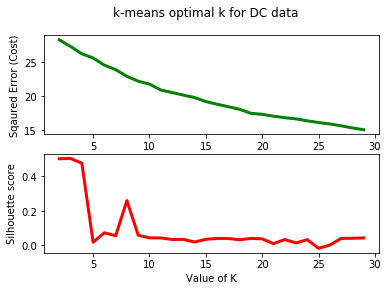

In [68]:
NYC_grouped_clustering = NYC_grouped_mean.drop('Neighborhood', 1)
cost =[] 
score = []
for i in range(2, 30): 
    KM = KMeans(n_clusters=i, random_state=0).fit(NYC_grouped_clustering) 
      
    # calculates squared error and silhouette score for the clustered points
        
    cost.append(KM.inertia_)
    score.append(metrics.silhouette_score(NYC_grouped_clustering, KM.labels_, metric='euclidean'))
    
fig, axs = plt.subplots(2)
fig.suptitle('k-means optimal k for DC data')
axs[0].plot(range(2, 30), cost, color ='g', linewidth ='3')
axs[0].set_xlabel("Value of K") 
axs[0].set_ylabel("Sqaured Error (Cost)")
axs[1].plot(range(2, 30), score, color='r', linewidth = '3')
axs[1].set_xlabel("Value of K") 
axs[1].set_ylabel("Silhouette score")

In [70]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(NYC_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 3, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 4, 1, 0, 0, 1, 1,
       1, 1, 0, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 3, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 0, 1, 0, 3, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1,

In [71]:
df_NYC_grouped_neigh_clusters = pd.DataFrame(NYC_grouped_mean['Neighborhood'])
df_NYC_grouped_neigh_clusters['KM Cluster Labels'] = kmeans.labels_
print(df_NYC_grouped_neigh_clusters.shape)
df_NYC_grouped_neigh_clusters.head()

(302, 2)


Neighborhood  KM Cluster Labels
0       Allerton                  0
1       Annadale                  0
2  Arden Heights                  0
3      Arlington                  1
4       Arrochar                  0

In [72]:
df_NYC_neigh3 = pd.merge(df_NYC_neigh2, df_NYC_grouped_neigh_clusters, on='Neighborhood', how='left')
print(df_NYC_neigh3.shape)
df_NYC_neigh3.head(20)

(306, 8)


Neighborhood  Total Venues  E-scores        Borough   Latitude  \
0             Allerton            28  3.035141          Bronx  40.865788   
1             Annadale            12  2.210254  Staten Island  40.538114   
2        Arden Heights             5  1.609438  Staten Island  40.549286   
3            Arlington             5  1.609438  Staten Island  40.635325   
4             Arrochar            19  2.652588  Staten Island  40.596313   
5              Arverne            20  2.579844         Queens  40.589144   
6              Astoria            98  3.819812         Queens  40.768509   
7      Astoria Heights            12  2.369382         Queens  40.770317   
8           Auburndale            18  2.813355         Queens  40.761730   
9           Bath Beach            51  3.574859       Brooklyn  40.599519   
10   Battery Park City            70  3.601055      Manhattan  40.711932   
11           Bay Ridge            83  3.709878       Brooklyn  40.625801   
12         Bay Terrace            45  3.352115         Queens  40.782843   
13         Bay Terrace            45  3.352115  Staten Island  40.553988   
14          Baychester            18  2.813355          Bronx  40.866858   
15             Bayside            72  3.770003         Queens  40.766041   
16           Bayswater             2  0.693147         Queens  40.611322   
17        Bedford Park            37  2.922363          Bronx  40.870185   
18  Bedford Stuyvesant            29  3.062433       Brooklyn  40.687232   
19          Beechhurst            13  2.564949         Queens  40.792781   

    Longitude  TotalCrimes  KM Cluster Labels  
0  -73.859319          211                  0  
1  -74.178549           12                  0  
2  -74.185887           19                  0  
3  -74.165104          120                  1  
4  -74.067124           77                  0  
5  -73.791992          166                  1  
6  -73.915654         1295                  1  
7  -73.894680           71                  0  
8  -73.791762           32                  1  
9  -73.998752          605                  1  
10 -74.016869          135                  1  
11 -74.030621          204                  1  
12 -73.776802           12                  1  
13 -74.139166           37                  1  
14 -73.835798          111                  1  
15 -73.774274           39                  1  
16 -73.765968            8                  1  
17 -73.885512         1397                  0  
18 -73.941785         1040                  1  
19 -73.804365           10                  0

In [73]:
df_NYC_neigh3.to_csv('NYC_neigh3.csv')

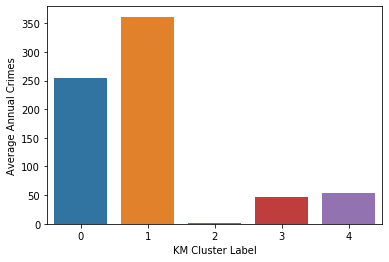

In [74]:
df_NYC_neigh3_clustergrouped = df_NYC_neigh3.groupby('KM Cluster Labels').mean().reset_index()
df_NYC_neigh3_clustergrouped1 = df_NYC_neigh3_clustergrouped[['KM Cluster Labels','TotalCrimes']]
df_NYC_neigh3_clustergrouped1.columns = ['KM Cluster Label','Average Annual Crimes']
ax = sns.barplot(x="KM Cluster Label", y="Average Annual Crimes", data=df_NYC_neigh3_clustergrouped1)

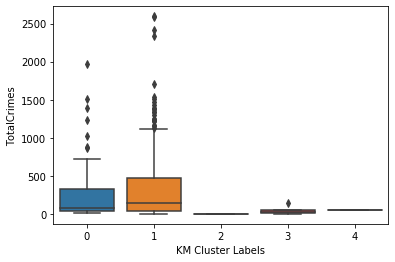

In [75]:
sns.boxplot(x="KM Cluster Labels", y="TotalCrimes", data=df_NYC_neigh3)

# Visualize NYC data with histogram, scatter plot, and preliminary polynomial fit

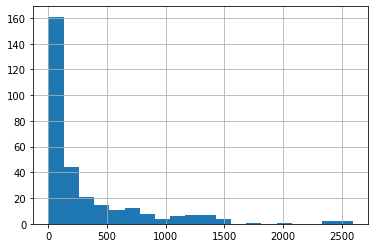

In [76]:
# Plot histogram of total neighborhood crimes for 2019
df_NYC_neigh3['TotalCrimes'].hist(bins = 20)


Model:       4         3         2
2.86 x - 2.195 x + 5.495 x - 7.669 x + 118.6


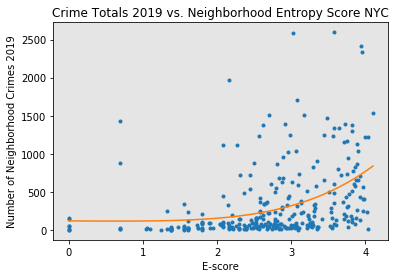

In [77]:
x = df_NYC_neigh3['E-scores']
y = df_NYC_neigh3['TotalCrimes']

f = np.polyfit(x, y, 4)
p = np.poly1d(f)
print('Model:', p)
PlotPolly(p, x, y, 'E-score', 'Number of Neighborhood Crimes 2019', 'Crime Totals 2019 vs. Neighborhood Entropy Score NYC')

### Look at the data for one borough of NYC

In [78]:
df_NYC_neigh_cl1 = df_NYC_neigh3.loc[df_NYC_neigh3['Borough'] == 'Queens']
df_NYC_neigh_cl1.head()

Neighborhood  Total Venues  E-scores Borough   Latitude  Longitude  \
5           Arverne            20  2.579844  Queens  40.589144 -73.791992   
6           Astoria            98  3.819812  Queens  40.768509 -73.915654   
7   Astoria Heights            12  2.369382  Queens  40.770317 -73.894680   
8        Auburndale            18  2.813355  Queens  40.761730 -73.791762   
12      Bay Terrace            45  3.352115  Queens  40.782843 -73.776802   

    TotalCrimes  KM Cluster Labels  
5           166                  1  
6          1295                  1  
7            71                  0  
8            32                  1  
12           12                  1

Model:         4         3         2
0.2697 x + 2.855 x + 31.62 x - 81.72 x + 63.82


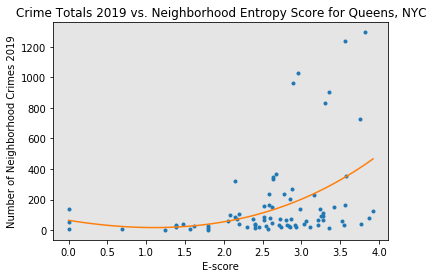

In [79]:
x = df_NYC_neigh_cl1['E-scores']
y = df_NYC_neigh_cl1['TotalCrimes']
f = np.polyfit(x, y, 4)
p = np.poly1d(f)
print('Model:', p)
PlotPolly(p, x, y, 'E-score', 'Number of Neighborhood Crimes 2019', 'Crime Totals 2019 vs. Neighborhood Entropy Score for Queens, NYC')

(0, 1376.24898643236)

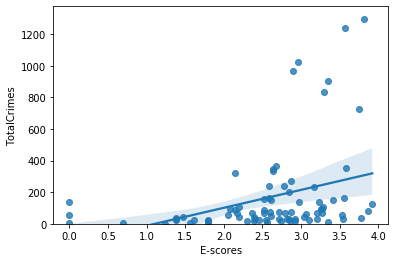

In [80]:
sns.regplot(x="E-scores", y="TotalCrimes", data=df_NYC_neigh_cl1)
plt.ylim(0,)

# Cluster analysis on NYC crime data using DBSCAN

In [81]:
from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.preprocessing import StandardScaler
Clus_dataSet = df_NYC_neigh3[['Total Venues','TotalCrimes','E-scores']]
Clus_dataSet = StandardScaler().fit_transform(Clus_dataSet)

# Compute DBSCAN
db = DBSCAN(eps=0.4, min_samples=6).fit(Clus_dataSet)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
df_NYC_neigh3["DBSCAN_Labels"]=labels

realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels)) 
print(metrics.silhouette_score(Clus_dataSet, labels, metric='euclidean'))
print(labels)
print(clusterNum)
df_NYC_neigh3.head(10)

0.3711509740057709
[ 0  0  0  0  0  0 -1  0  0 -1  0  0  0  0  0  0 -1 -1 -1  0  0  0  0 -1
  0  0  0  0  1  0  0  0  0  0  0  0  1  2  0  0  0  0  0  0  1  1  0  0
 -1  0 -1  1 -1  0  0 -1 -1  0  0  1  1  0  1  0  0 -1 -1  0  0  0  0  0
 -1  0  0 -1  0  0  0  0 -1 -1  0  1  0  0 -1  0  0  0  0  0  0  0 -1 -1
  0  1  0  1  0  0 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  0  0
  0  0  1  0  1  2 -1  0  0  0  0  0  0  0  0  0  2  0  0 -1  0 -1 -1 -1
  0  0  0  0  0 -1  0  0  0  1  0  1  0 -1  0  0 -1 -1  0  0  0  0 -1 -1
  0  0  0  0  0 -1  0  0 -1 -1  0  0 -1  0 -1  0 -1  0  0 -1 -1 -1  2  0
  0  0  0  0 -1  0  0  1  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0
  0  2  0  0  0  0  0 -1  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0
  0  0  0  0  0  0  0 -1  0  0  0  0 -1  2 -1  0  0  0  1  0  0  0 -1  0
  0  0  0  0  0  1  0  1  0  2  0  0  0 -1  0  1  0  0  1  1  0  0  0  0
 -1 -1  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  1]
4


Neighborhood  Total Venues  E-scores        Borough   Latitude  \
0         Allerton            28  3.035141          Bronx  40.865788   
1         Annadale            12  2.210254  Staten Island  40.538114   
2    Arden Heights             5  1.609438  Staten Island  40.549286   
3        Arlington             5  1.609438  Staten Island  40.635325   
4         Arrochar            19  2.652588  Staten Island  40.596313   
5          Arverne            20  2.579844         Queens  40.589144   
6          Astoria            98  3.819812         Queens  40.768509   
7  Astoria Heights            12  2.369382         Queens  40.770317   
8       Auburndale            18  2.813355         Queens  40.761730   
9       Bath Beach            51  3.574859       Brooklyn  40.599519   

   Longitude  TotalCrimes  KM Cluster Labels  DBSCAN_Labels  
0 -73.859319          211                  0              0  
1 -74.178549           12                  0              0  
2 -74.185887           19                  0              0  
3 -74.165104          120                  1              0  
4 -74.067124           77                  0              0  
5 -73.791992          166                  1              0  
6 -73.915654         1295                  1             -1  
7 -73.894680           71                  0              0  
8 -73.791762           32                  1              0  
9 -73.998752          605                  1             -1

### Save NYC dataframe to a CSV file

In [82]:
df_NYC_neigh3.to_csv('NYC_neigh3.csv')

In [83]:
df_NYC_neigh3.shape

(306, 9)

### View DBSCAN label counts for NYC

In [84]:
df_NYC_DBSCANgroups = pd.DataFrame(df_NYC_neigh3.groupby('DBSCAN_Labels').count())
df_NYC_DBSCANgroups[['KM Cluster Labels']].rename(columns={'KM Cluster Labels':'Number of Neighborhoods in Cluster'}).head()


Number of Neighborhoods in Cluster
DBSCAN_Labels                                    
-1                                             55
 0                                            220
 1                                             24
 2                                              7

### Plot NYC neighborhoods color coded by DBSCAN cluster labels

In [85]:
# create map
map_clusters = folium.Map(location=[NYClatitude, NYClongitude], zoom_start=12)
# set color scheme for the clusters
x = np.arange(clusterNum)
ys = [i + x + (i*x)**2 for i in range(clusterNum)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_NYC_neigh3['Latitude'], df_NYC_neigh3['Longitude'], df_NYC_neigh3['Neighborhood'], df_NYC_neigh3['DBSCAN_Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

     
map_clusters

### Visualize clusters in scatterplot of Total Crimes vs. E-scores for NYC data

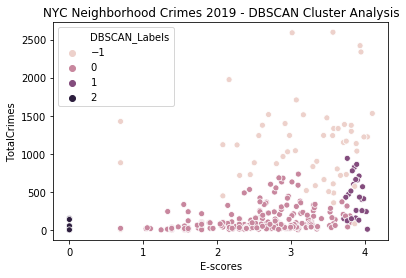

In [86]:
sns.scatterplot('E-scores', 'TotalCrimes', data=df_NYC_neigh3, hue='DBSCAN_Labels')
plt.title('NYC Neighborhood Crimes 2019 - DBSCAN Cluster Analysis')
plt.show()

### Analyze NYC DBSCAN cluster statistics using bar plots

Text(0.5, 0, 'DBSCAN Clusters')

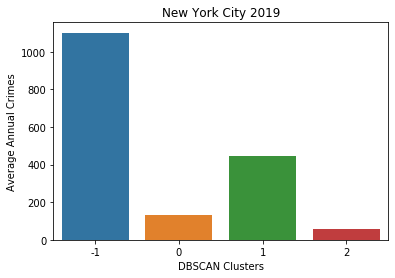

In [87]:
#Plot average annual crime totals vs. cluster labels.
df_NYC_neigh3_clustergrouped = df_NYC_neigh3.groupby('DBSCAN_Labels').mean().reset_index()
df_NYC_neigh3_clustergrouped2 = df_NYC_neigh3_clustergrouped[['DBSCAN_Labels','TotalCrimes']]
df_NYC_neigh3_clustergrouped2.columns = ['DBSCAN_Labels','Average Annual Crimes']
ax = sns.barplot(x="DBSCAN_Labels", y="Average Annual Crimes", data=df_NYC_neigh3_clustergrouped2)
ax.set_title('New York City 2019')
ax.set_xlabel('DBSCAN Clusters')

Text(0.5, 0, 'DBSCAN Clusters')

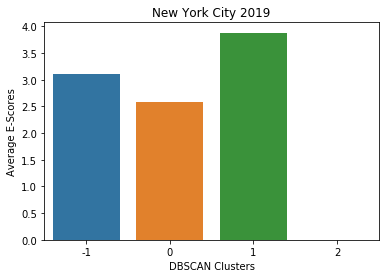

In [88]:
# Plot average E-Scores vs. cluster labels
df_NYC_neigh3_clustergrouped3 = df_NYC_neigh3_clustergrouped[['DBSCAN_Labels','E-scores']]
df_NYC_neigh3_clustergrouped3.columns = ['DBSCAN_Labels','Average E-Scores']
ax = sns.barplot(x="DBSCAN_Labels", y="Average E-Scores", data=df_NYC_neigh3_clustergrouped3)
ax.set_title('New York City 2019')
ax.set_xlabel('DBSCAN Clusters')

Text(0.5, 0, 'DBSCAN Clusters')

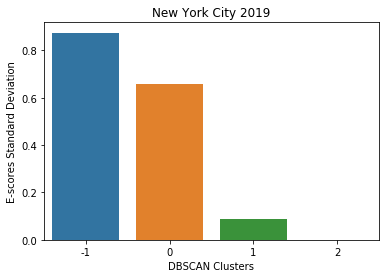

In [89]:
# Plot E-score standard deviation vs. cluster labels
df_NYC_neigh3_clustergroupedSTD = df_NYC_neigh3.groupby('DBSCAN_Labels').std().reset_index()
df_NYC_neigh3_clustergrouped4 = df_NYC_neigh3_clustergroupedSTD[['DBSCAN_Labels','E-scores']]
df_NYC_neigh3_clustergrouped4.columns = ['DBSCAN_Labels','E-scores Standard Deviation']
ax = sns.barplot(x="DBSCAN_Labels", y="E-scores Standard Deviation", data=df_NYC_neigh3_clustergrouped4)
ax.set_title('New York City 2019')
ax.set_xlabel('DBSCAN Clusters')

# Cluster analysis on Washington DC crime data using DBSCAN¶

In [90]:
Clus_dataSet = df_DC_neigh3[['Total Venues','TotalCrimes','E-scores']]
Clus_dataSet = StandardScaler().fit_transform(Clus_dataSet)

# Compute DBSCAN
db = DBSCAN(eps=0.35, min_samples=9).fit(Clus_dataSet)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
df_DC_neigh3["DBSCAN_Labels"]=labels

realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels)) 
print(metrics.silhouette_score(Clus_dataSet, labels, metric='euclidean'))
print(labels)
print(realClusterNum)
df_DC_neigh3.head(10)

0.3825240296600078
[ 0 -1 -1  0  0  0  0 -1  0 -1 -1 -1 -1 -1  0  0  0 -1  0 -1 -1  0  0  0
 -1  0 -1  0 -1 -1  0  0 -1 -1 -1  0  0  0  0  0  0 -1  0  0  0 -1  0  0
  0  0  0 -1  0  0 -1 -1  0 -1 -1 -1  0  0  0  0 -1 -1  0  0  0  0  0  0
  0 -1 -1 -1  0  0 -1  0  0  0 -1  0 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1  0
  0 -1  0 -1  0 -1 -1  0 -1  0  0  0  0  0  0  0 -1 -1 -1  0  0 -1 -1  0
 -1  0  0 -1  0  0 -1  0  0  0  0]
1


Neighborhood   Latitude  Longitude  Total Venues  E-scores  \
0       16th Street Heights  38.950315 -77.033559            14  2.639057   
1              Adams Morgan  38.920472 -77.042391            56  3.852065   
2  American University Park  38.947612 -77.090250             2  0.693147   
3                 Arboretum  38.914860 -76.972490            16  2.685945   
4             Barnaby Woods  38.975433 -77.060174             4  1.386294   
5                Barry Farm  38.859255 -76.997281             6  1.560710   
6                  Bellevue  38.826952 -77.009271             4  1.386294   
7                   Benning  38.891885 -76.948884            16  2.772589   
8             Benning Ridge  38.881161 -76.938203             4  1.386294   
9              Bloomingdale  38.918226 -77.011159            18  2.813355   

   KM Cluster Labels  TotalCrimes  ViolentCrimes  PropertyCrimes  \
0                  0           78              4              74   
1                  0          473             39             434   
2                  0           35              4              31   
3                  0           86             13              73   
4                  0           36              0              36   
5                  0          119             40              79   
6                  0          151             45             106   
7                  0          307             55             252   
8                  0          110             32              78   
9                  0          321             40             281   

   MVPolyFit_TotalCrimes  PolyFit_TotalCrimes  DBSCAN_Labels  
0             196.658262           202.120950              0  
1             485.234811           649.467832             -1  
2              31.960649           158.951165             -1  
3             176.043038           213.447780              0  
4             123.446829           115.166207              0  
5             174.856919           106.762922              0  
6             123.446829           115.166207              0  
7             268.541880           235.987879             -1  
8             123.446829           115.166207              0  
9             234.776973           247.303064             -1

In [91]:
df_DC_neigh3.to_csv('DC_neigh3.csv')

In [92]:
df_NYC_DBSCANgroups = pd.DataFrame(df_DC_neigh3.groupby('DBSCAN_Labels').count())
df_NYC_DBSCANgroups[['KM Cluster Labels']].rename(columns={'KM Cluster Labels':'Number of Neighborhoods in Cluster'}).head()


Number of Neighborhoods in Cluster
DBSCAN_Labels                                    
-1                                             56
 0                                             75

## Plot DC neighborhoods color coded by DBSCAN cluster labels

In [93]:
# create map
map_clusters = folium.Map(location=[DClatitude, DClongitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(clusterNum)
ys = [i + x + (i*x)**2 for i in range(clusterNum)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_DC_neigh3['Latitude'], df_DC_neigh3['Longitude'], df_DC_neigh3['Neighborhood'], df_DC_neigh3['DBSCAN_Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Visualize clusters in scatterplot of Total Crimes vs. E-scores for DC data

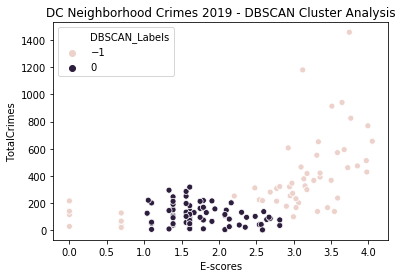

In [94]:
sns.scatterplot('E-scores', 'TotalCrimes', data=df_DC_neigh3, hue='DBSCAN_Labels')
plt.title('DC Neighborhood Crimes 2019 - DBSCAN Cluster Analysis')
plt.show()

## Use barplots to understand cluster statistics for DC data

Text(0.5, 0, 'DBSCAN Clusters')

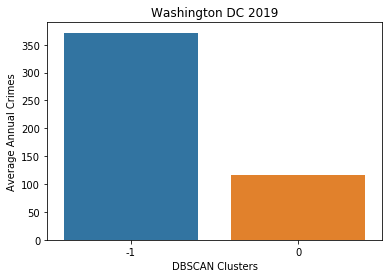

In [95]:
df_DC_neigh3_clustergrouped = df_DC_neigh3.groupby('DBSCAN_Labels').mean().reset_index()
df_DC_neigh3_clustergrouped2 = df_DC_neigh3_clustergrouped[['DBSCAN_Labels','TotalCrimes']]
df_DC_neigh3_clustergrouped2.columns = ['DBSCAN_Labels','Average Annual Crimes']
ax = sns.barplot(x="DBSCAN_Labels", y="Average Annual Crimes", data=df_DC_neigh3_clustergrouped2)
ax.set_title('Washington DC 2019')
ax.set_xlabel('DBSCAN Clusters')

Text(0.5, 0, 'DBSCAN Clusters')

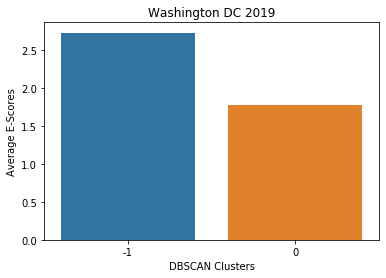

In [96]:
df_DC_neigh3_clustergrouped3 = df_DC_neigh3_clustergrouped[['DBSCAN_Labels','E-scores']]
df_DC_neigh3_clustergrouped3.columns = ['DBSCAN_Labels','Average E-Scores']
ax = sns.barplot(x="DBSCAN_Labels", y="Average E-Scores", data=df_DC_neigh3_clustergrouped3)
ax.set_title('Washington DC 2019')
ax.set_xlabel('DBSCAN Clusters')

Text(0.5, 0, 'DBSCAN Clusters')

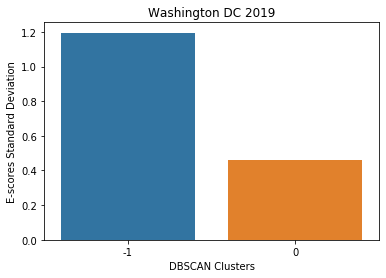

In [97]:
df_DC_neigh3_clustergroupedSTD = df_DC_neigh3.groupby('DBSCAN_Labels').std().reset_index()
df_DC_neigh3_clustergrouped4 = df_DC_neigh3_clustergroupedSTD[['DBSCAN_Labels','E-scores']]
df_DC_neigh3_clustergrouped4.columns = ['DBSCAN_Labels','E-scores Standard Deviation']
ax = sns.barplot(x="DBSCAN_Labels", y="E-scores Standard Deviation", data=df_DC_neigh3_clustergrouped4)
ax.set_title('Washington DC 2019')
ax.set_xlabel('DBSCAN Clusters')

# Use polynomial regression to predict total crimes using venue count and venue entropy score as features

## Polynomial regression on New York neighborhood data

In [99]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
X = df_NYC_neigh3[['Total Venues','E-scores']].values
y = df_NYC_neigh3['TotalCrimes'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
Input = [('scale',StandardScaler()), ('polynomial', PolynomialFeatures(degree=1, include_bias=False)), ('model',LinearRegression())]
pipe = Pipeline(Input)
pipe.fit(X_train,y_train)
ypipe = pipe.predict(X_test)
y1score = pipe.score(X_test,y_test)
print ('R2 score =', y1score)


R2 score = 0.1549922514213358


In [100]:
Rcross = cross_val_score(pipe, X, y, cv=4, scoring='r2')
Rcross.mean()

0.13980574886821445

In [101]:
y

array([ 211,   12,   19,  120,   77,  166, 1295,   71,   32,  605,  135,
        204,   12,   37,  111,   39,    8, 1397, 1040,   10,   22,   16,
         18,  581,   95,    2,   72,    3,  708,   58,    1,   40,  251,
         24,  531,  156,  240,   54,  600,   35,  235,   10,   70,  104,
        469,  147,  202,   32, 1472,    2, 1222,    9, 1374,   26,  326,
       2337,  716,   31,   83,  823,  157,   89,  400,   68,   52,  870,
       2589,  486,  204,   35,  221,  187,  485,   50,   21, 1530,   80,
         96,   69,  129, 1707, 1974,  497,  409,  284,   67, 1425,  149,
         42,    7,  100,  365,   30,   29, 1241, 1026,    1,  776,  253,
        655,  141,    6, 1239, 1332,  109,   29,  101,  184,  239,   17,
         34,   86,   25,   20,   15,  306, 1385,  882,  587,   82,   53,
         52,  429,   24,  599,  151,  661,  106,  146,  630,  128,   18,
         85,   24,  217,   31,    1,  369,   38,  728,   30,  503,  356,
        901,   35,  237,   97,   57,   40,  716,  3

## Evalutate NYC regression model with distribution plots

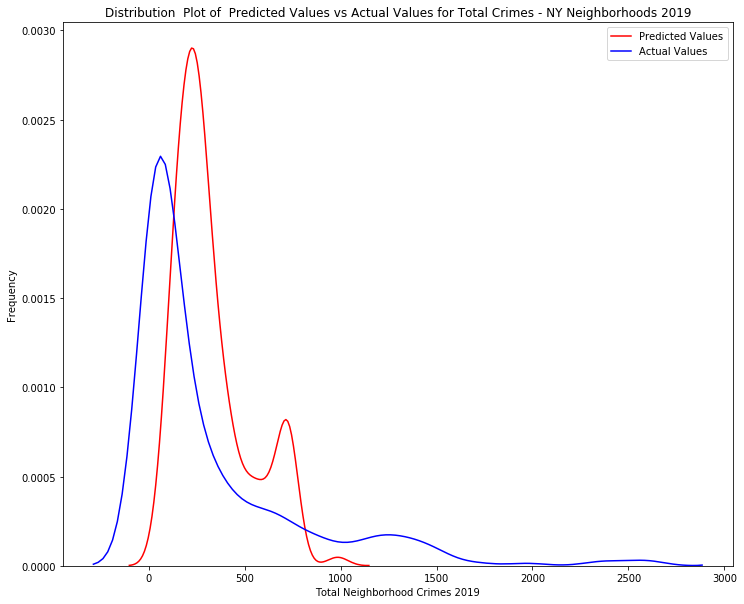

In [102]:
Title = 'Distribution  Plot of  Predicted Values vs Actual Values for Total Crimes - NY Neighborhoods 2019'
y1 = pipe.predict(X)
y2 = y
DistributionPlot(y1, y2, "Predicted Values", "Actual Values", Title)

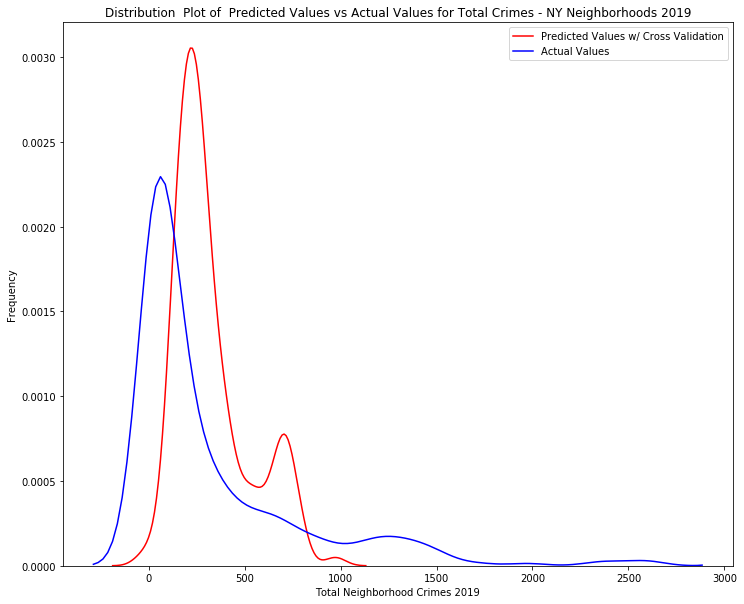

In [103]:
Title = 'Distribution  Plot of  Predicted Values vs Actual Values for Total Crimes - NY Neighborhoods 2019'
y1 = cross_val_predict(pipe,X, y,cv=4)
y2 = y
DistributionPlot(y1, y2, "Predicted Values w/ Cross Validation", "Actual Values", Title)

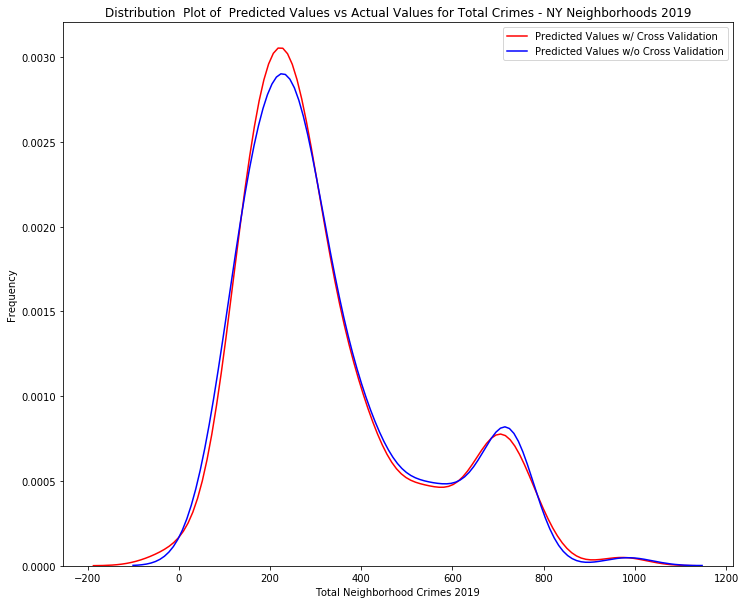

In [104]:
Title = 'Distribution  Plot of  Predicted Values vs Actual Values for Total Crimes - NY Neighborhoods 2019'
y1 = cross_val_predict(pipe,X, y,cv=4)
y2 = pipe.predict(X)
DistributionPlot(y1, y2, "Predicted Values w/ Cross Validation", "Predicted Values w/o Cross Validation", Title)

In [105]:
df_NYC_neigh4 = df_NYC_neigh3
indexNames = df_NYC_neigh4[df_NYC_neigh4['DBSCAN_Labels'] == -1].index
df_NYC_neigh4.drop(indexNames , inplace=True)
print(df_NYC_neigh4.shape)
df_NYC_neigh4.head(100)

(251, 9)


Neighborhood  Total Venues  E-scores        Borough   Latitude  \
0         Allerton            28  3.035141          Bronx  40.865788   
1         Annadale            12  2.210254  Staten Island  40.538114   
2    Arden Heights             5  1.609438  Staten Island  40.549286   
3        Arlington             5  1.609438  Staten Island  40.635325   
4         Arrochar            19  2.652588  Staten Island  40.596313   
..             ...           ...       ...            ...        ...   
119       Grasmere            25  2.775262  Staten Island  40.598268   
120      Gravesend            22  2.602381       Brooklyn  40.595260   
121    Great Kills            21  2.755550  Staten Island  40.549480   
122     Greenpoint           100  3.745286       Brooklyn  40.730201   
123     Greenridge             7  1.747868  Staten Island  40.555295   

     Longitude  TotalCrimes  KM Cluster Labels  DBSCAN_Labels  
0   -73.859319          211                  0              0  
1   -74.178549           12                  0              0  
2   -74.185887           19                  0              0  
3   -74.165104          120                  1              0  
4   -74.067124           77                  0              0  
..         ...          ...                ...            ...  
119 -74.076674           82                  1              0  
120 -73.973471           53                  0              0  
121 -74.149324           52                  0              0  
122 -73.954241          429                  1              1  
123 -74.170794           24                  0              0  

[100 rows x 9 columns]

In [106]:
X = df_NYC_neigh4[['Total Venues','E-scores']].values
y = df_NYC_neigh4['TotalCrimes'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
Input = [('scale',StandardScaler()), ('polynomial', PolynomialFeatures(degree=3, include_bias=False)), ('model',LinearRegression())]
pipe = Pipeline(Input)
pipe.fit(X_train,y_train)
ypipe = pipe.predict(X_test)
y1score = pipe.score(X_test,y_test)
print ('R2 score =', y1score)

R2 score = 0.2522966352390953


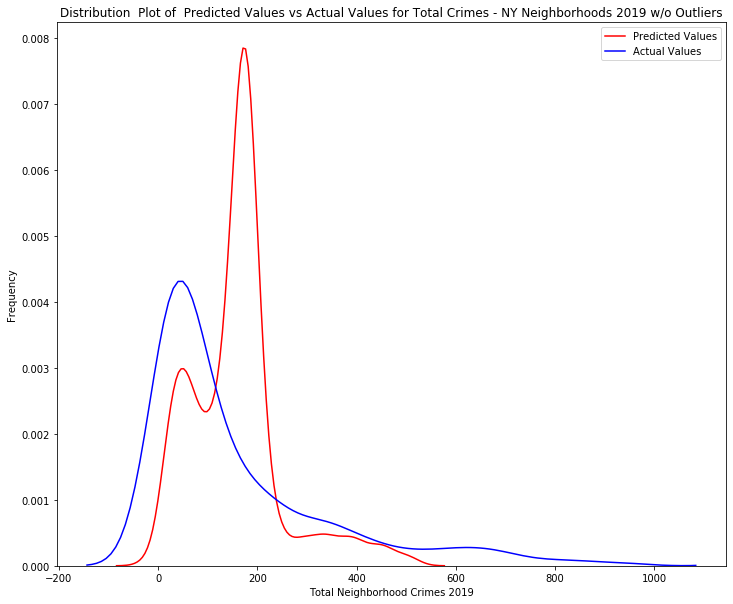

In [107]:
Title = 'Distribution  Plot of  Predicted Values vs Actual Values for Total Crimes - NY Neighborhoods 2019 w/o Outliers'
y1 = pipe.predict(X)
y2 = y
DistributionPlot(y1, y2, "Predicted Values", "Actual Values", Title)

## Polynomial regression on Washington DC neighborhood data

In [118]:
X = df_DC_neigh3[['Total Venues','E-scores']].values
y = df_DC_neigh3['TotalCrimes'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
Input = [('scale',StandardScaler()), ('polynomial', PolynomialFeatures(degree=5, include_bias=False)), ('model',LinearRegression())]
pipe = Pipeline(Input)
pipe.fit(X_train,y_train)
ypipe = pipe.predict(X_test)
y1score = pipe.score(X_test,y_test)
print ('R2 score =', y1score)

R2 score = 0.3006960039737834


In [119]:
Rcross = cross_val_score(pipe, X, y, cv=3, scoring='r2')
print(Rcross.mean())
Rcross

-5.199784770338439


array([ -2.2061425 ,  -0.42900936, -12.96420245])

## Evaluate DC regression model with distribution plots

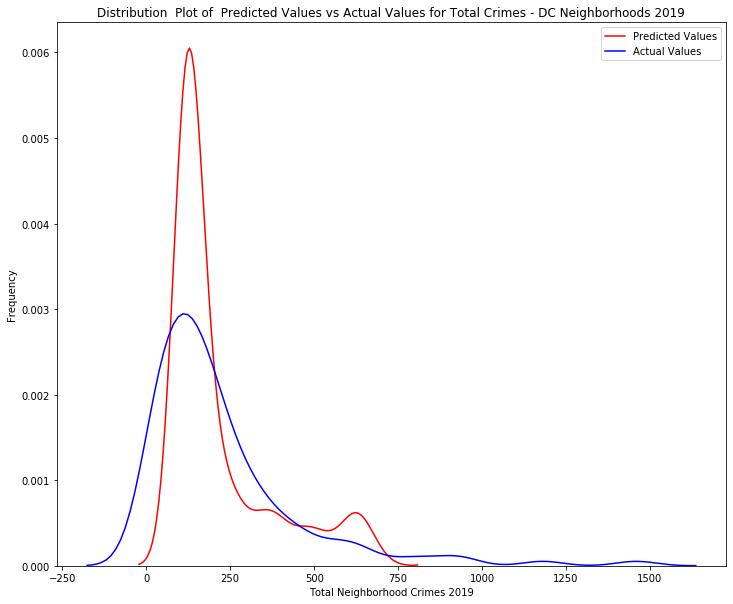

In [352]:
Title = 'Distribution  Plot of  Predicted Values vs Actual Values for Total Crimes - DC Neighborhoods 2019'
y1 = pipe.predict(X)
y2 = y
DistributionPlot(y1, y2, "Predicted Values", "Actual Values", Title)

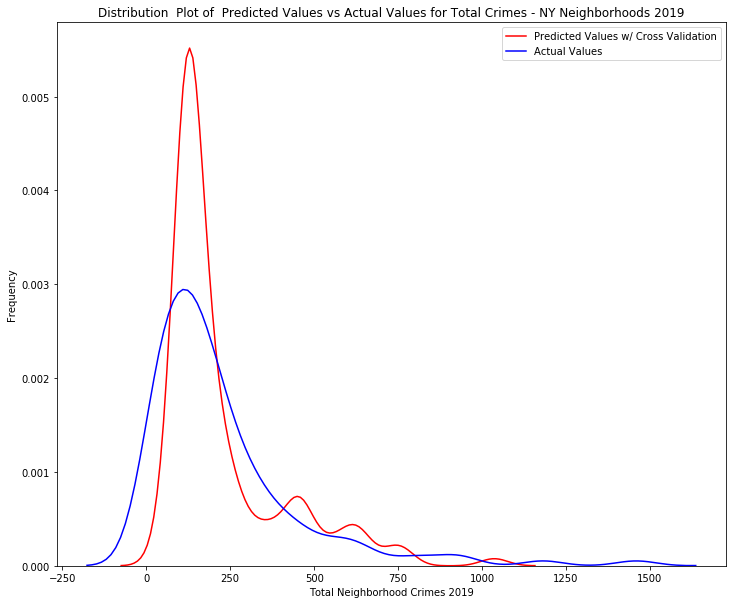

In [353]:
Title = 'Distribution  Plot of  Predicted Values vs Actual Values for Total Crimes - NY Neighborhoods 2019'
y1 = cross_val_predict(pipe,X, y,cv=4)
y2 = y
DistributionPlot(y1, y2, "Predicted Values w/ Cross Validation", "Actual Values", Title)

In [144]:
df_DC_neigh5 = df_DC_neigh3
indexNames = df_DC_neigh5[df_DC_neigh5['DBSCAN_Labels'] == -1].index
df_DC_neigh5.drop(indexNames , inplace=True)
print(df_DC_neigh5.shape)
df_DC_neigh5.head()

(96, 12)


Neighborhood   Latitude  Longitude  Total Venues  E-scores  \
0       16th Street Heights  38.950315 -77.033559            15  2.708050   
2  American University Park  38.947612 -77.090250             2  0.693147   
3                 Arboretum  38.914860 -76.972490            14  2.639057   
4             Barnaby Woods  38.975433 -77.060174             4  1.386294   
5                Barry Farm  38.859255 -76.997281             6  1.560710   

   KM Cluster Labels  TotalCrimes  ViolentCrimes  PropertyCrimes  \
0                  1           78              4              74   
2                  2           35              4              31   
3                  1           86             13              73   
4                  6           36              0              36   
5                  1          119             40              79   

   MVPolyFit_TotalCrimes  PolyFit_TotalCrimes  DBSCAN_Labels  
0             218.080356           218.364999              0  
2              56.005149           156.390580              1  
3             192.061252           201.502758              0  
4             114.561832           115.138064              0  
5             158.663420           106.784891              0

In [145]:
X = df_DC_neigh5[['Total Venues','E-scores']].values
y = df_DC_neigh5['TotalCrimes'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
Input = [('scale',StandardScaler()), ('polynomial', PolynomialFeatures(degree=1, include_bias=False)), ('model',LinearRegression())]
pipe = Pipeline(Input)
pipe.fit(X_train,y_train)
ypipe = pipe.predict(X_test)
y1score = pipe.score(X_test,y_test)
print ('R2 score =', y1score)


R2 score = 0.40117163375404197


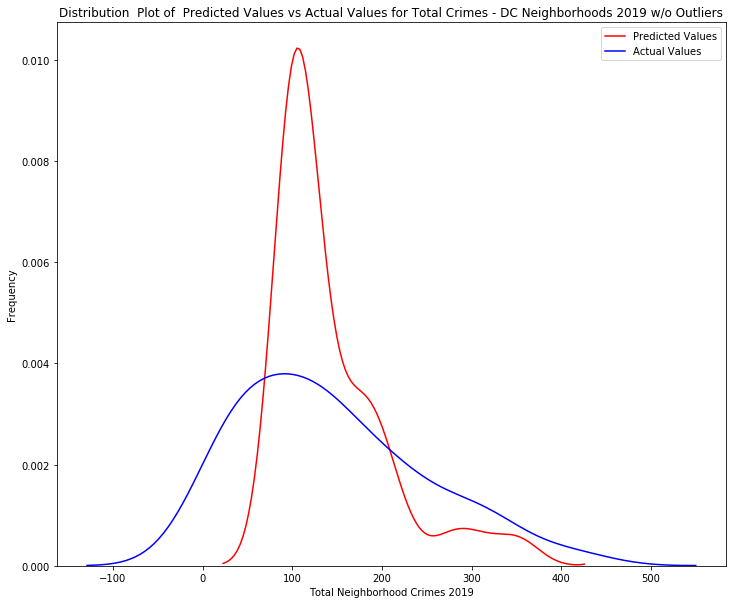

In [146]:
Title = 'Distribution  Plot of  Predicted Values vs Actual Values for Total Crimes - DC Neighborhoods 2019 w/o Outliers'
y1 = pipe.predict(X)
y2 = y
DistributionPlot(y1, y2, "Predicted Values", "Actual Values", Title)